In [1]:
# Import libraries and modules
import os
import itertools
import pandas as pd
import numpy as np
import datetime as dt
from math import sqrt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

%matplotlib inline

In [2]:
# Increase maximum width in characters of columns - will put all columns in same line in console readout
pd.set_option('expand_frame_repr', False)

# Be able to read entire value in each column (no longer truncating values)
pd.set_option('display.max_colwidth', None)

# Increase number of rows printed out in console
pd.set_option('display.max_rows', 200)

# Increase number of columns printed out in console
pd.set_option('display.max_columns', 200)

# Set aesthetic parameters of seaborn plots
sns.set()

# Data Ingestion

In [3]:
# Open Hungarian data set
with open('hungarian.data', 'r') as myfile:
    file = []
    for line in myfile:
        line = line.replace(" ", ", ")
        # Add comma to end of each line
        line = line.replace(os.linesep, ',' + os.linesep)
        line = line.split(', ')
        file.extend(line)

file = [value.replace(",\n", "") for value in file]
# Remove empty strings from list
file = list(filter(None, file))

# Convert list to lists of list
attributes_per_patient = int(len(file)/294)    # len(file)/number of patients
i = 0
new_file = []
while i < len(file):
    new_file.append(file[i:i+attributes_per_patient])
    i += attributes_per_patient

# List of column names
headers = ['id', 'ccf', 'age', 'sex', 'painloc', 'painexer', 'relrest', 'pncaden', 'cp', 'trestbps', 'htn', 'chol',
           'smoke', 'cigs', 'years', 'fbs', 'dm', 'famhist', 'restecg', 'ekgmo', 'ekgday', 'ekgyr', 'dig', 'prop',
           'nitr', 'pro', 'diuretic', 'proto', 'thaldur', 'thaltime', 'met', 'thalach', 'thalrest', 'tpeakbps',
           'tpeakbpd', 'dummy', 'trestbpd', 'exang', 'xhypo', 'oldpeak', 'slope', 'rldv5', 'rldv5e', 'ca', 'restckm',
           'exerckm', 'restef', 'restwm', 'exeref', 'exerwm', 'thal', 'thalsev', 'thalpul', 'earlobe', 'cmo',
           'cday', 'cyr', 'num', 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox',
           'rcadist', 'lvx1', 'lvx2', 'lvx3', 'lvx4', 'lvf', 'cathef', 'junk', 'name']

# Convert lists of list into DataFrame and supply column names
hungarian = pd.DataFrame(new_file, columns=headers)

# Data Cleaning

In [4]:
# List of columns to drop
cols_to_drop =['ccf', 'pncaden', 'smoke', 'cigs', 'years', 'dm', 'famhist', 'dig', 'ca', 'restckm', 'exerckm',
               'restef', 'restwm', 'exeref', 'exerwm', 'thal', 'thalsev', 'thalpul', 'earlobe', 'lmt',
               'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist', 'lvx1',
               'cathef', 'junk', 'name', 'thaltime', 'xhypo', 'slope', 'dummy', 'lvx1', 'lvx2']

# Drop columns from above list
hungarian = hungarian.drop(columns=cols_to_drop)

# Convert all columns to numeric
hungarian = hungarian.apply(pd.to_numeric)

### Fix possible patient id issues
# Find ids that are not unique to patients
print(hungarian.id.value_counts()[hungarian.id.value_counts()!=1])

# Fix id 1132 (two different patients are both assigned to this id) - give second patient next id number (id max + 1)
hungarian.loc[hungarian.loc[hungarian.id==1132].index[-1], 'id'] = hungarian.id.max() + 1

# Drop patients with "significant" number of missing values (use 10%, can adjust accordingly)
# Determine missing value percentage per patient (-9 is the missing attribute value)
missing_value_perc_per_patient = (hungarian == -9).sum(axis=1)[(hungarian == -9).sum(axis=1) > 0]\
                                     .sort_values(ascending=False)/len([x for x in hungarian.columns if x != 'id'])

# Remove patients with > 10% missing values
hungarian = hungarian.drop(missing_value_perc_per_patient[missing_value_perc_per_patient>0.10].index.values)

1132    2
Name: id, dtype: int64


## Impute Missing Values (-9 is missing value indicator per data dictionary)

In [5]:
### Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x: x[1])

# Use K-Nearest Neighbors (KNN) to impute missing values
# Method to scale continuous and binary variables (z-score standardization)
scaler = StandardScaler()
variables_not_to_use_for_imputation = ['ekgday', 'cmo', 'cyr', 'ekgyr', 'cday', 'ekgmo', 'num']

# Impute htn
impute_variable = 'htn'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use
fix_htn = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'nitr', 'pro', 'diuretic', 'exang',
                           'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_htn[value], prefix=value)
    fix_htn = fix_htn.join(one_hot)
    fix_htn = fix_htn.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_htn) if x != impute_variable]

# Create DataFrame with missing value(s) to predict on
predict = fix_htn.loc[fix_htn[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_htn.loc[~(fix_htn[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit and transform scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
htn_prediction = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print(f'The prediction for htn is {htn_prediction[0]}.')

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, 'htn'] = htn_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute restecg
impute_variable = 'restecg'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - added in 'htn'
fix_restecg = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'nitr', 'pro', 'diuretic', 'exang',
                           'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_restecg[value], prefix=value)
    fix_restecg = fix_restecg.join(one_hot)
    fix_restecg = fix_restecg.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_restecg) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_restecg.loc[fix_restecg[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_restecg.loc[~(fix_restecg[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit and transform scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
restecg_prediction = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print(f'The prediction for restecg is {restecg_prediction[0]}.')

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, 'restecg'] = restecg_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute prop
# Set y variable
impute_variable = 'prop'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'htn'
fix_prop = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'restecg', 'nitr', 'pro', 'diuretic', 'exang',
                           'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_prop[value], prefix=value)
    fix_prop = fix_prop.join(one_hot)
    fix_prop = fix_prop.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_prop) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_prop.loc[fix_prop[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_prop.loc[~(fix_prop[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit and transform scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
prop_prediction = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print(f'The prediction for prop is {prop_prediction[0]}.')

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, 'prop'] = prop_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute thaldur
# Set y variable
impute_variable = 'thaldur'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'prop'
fix_thaldur = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'exang', 'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_thaldur[value], prefix=value)
    fix_thaldur = fix_thaldur.join(one_hot)
    fix_thaldur = fix_thaldur.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_thaldur) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_thaldur.loc[fix_thaldur[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_thaldur.loc[~(fix_thaldur[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
thaldur_prediction = KNeighborsRegressor(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The prediction for thaldur is " + str(thaldur_prediction[0]) + ".")
# Round thaldur_prediction to integer
thaldur_prediction = round(number=thaldur_prediction[0])
print("The prediction for thaldur has been rounded to " + str(thaldur_prediction) + ".")

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, 'thaldur'] = thaldur_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute rldv5
# Set y variable
impute_variable = 'rldv5'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'prop'
fix_rldv5 = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'exang', 'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_rldv5[value], prefix=value)
    fix_rldv5 = fix_rldv5.join(one_hot)
    fix_rldv5 = fix_rldv5.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_rldv5) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_rldv5.loc[fix_rldv5[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_rldv5.loc[~(fix_rldv5[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
rldv5_prediction = KNeighborsRegressor(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The prediction for rldv5 is " + str(rldv5_prediction[0]) + ".")
# Round rldv5_prediction to integer
rldv5_prediction = round(number=rldv5_prediction[0])
print("The prediction for rldv5 has been rounded to " + str(rldv5_prediction) + ".")

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, 'rldv5'] = rldv5_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute met
# Set y variable
impute_variable = 'met'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'rldv5'
fix_met = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'exang', 'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_met[value], prefix=value)
    fix_met = fix_met.join(one_hot)
    fix_met = fix_met.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_met) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_met.loc[fix_met[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_met.loc[~(fix_met[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
met_prediction = KNeighborsRegressor(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The predictions for met are:")
print(met_prediction)

# Round met_prediction to integer
for i in range(len(met_prediction)):
    met_prediction[i] = round(number=met_prediction[i])
    print("The prediction for met_prediction" + "[" + str(i) + "]" + " has been rounded to " + str(met_prediction[i]) + ".")

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, impute_variable] = met_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute fbs
# Set y variable
impute_variable = 'fbs'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'met'
fix_fbs = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'exang', 'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_fbs[value], prefix=value)
    fix_fbs = fix_fbs.join(one_hot)
    fix_fbs = fix_fbs.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_fbs) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_fbs.loc[fix_fbs[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_fbs.loc[~(fix_fbs[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
fbs_prediction = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The predictions for fbs are:")
print(fbs_prediction)

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, impute_variable] = fbs_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute fbs
# Set y variable
impute_variable = 'proto'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'fbs'
fix_proto = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'fbs', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'exang', 'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_proto[value], prefix=value)
    fix_proto = fix_proto.join(one_hot)
    fix_proto = fix_proto.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_proto) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_proto.loc[fix_proto[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_proto.loc[~(fix_proto[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)
# Transform train_x
train_x = scaler.transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
proto_prediction = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The predictions for proto are:")
print(proto_prediction)

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, impute_variable] = proto_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute chol
impute_variable = 'chol'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'fbs'
fix_chol = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'fbs', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'proto', 'exang', 'lvx3', 'lvx4', 'lvf']


# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_chol[value], prefix=value)
    fix_chol = fix_chol.join(one_hot)
    fix_chol = fix_chol.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_chol) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_chol.loc[fix_chol[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_chol.loc[~(fix_chol[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")
    # Substract one to make k odd number
    k -= 1
    print(f"k is now {k}.")

# Predict value for predict_y
chol_prediction = KNeighborsRegressor(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The predictions for chol are:")
print(chol_prediction)

# Round chol_prediction to integer
for i in range(0, len(chol_prediction)):
    chol_prediction[i] = round(number=chol_prediction[i])
    print(f"The prediction for chol_prediction [{str(i)}] has been rounded to {chol_prediction[i]}.")

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, impute_variable] = chol_prediction

k is 17.
k is an odd number. Good to proceed.
The prediction for htn is 0.
k is 17.
k is an odd number. Good to proceed.
The prediction for restecg is 0.
k is 17.
k is an odd number. Good to proceed.
The prediction for prop is 1.
k is 17.
k is an odd number. Good to proceed.
The prediction for thaldur is 11.057187036308397.
The prediction for thaldur has been rounded to 11.0.
k is 17.
k is an odd number. Good to proceed.
The prediction for rldv5 is 12.66158057648588.
The prediction for rldv5 has been rounded to 13.0.
k is 17.
k is an odd number. Good to proceed.
The predictions for met are:
[5.26663321 7.21273683]
The prediction for met_prediction[0] has been rounded to 5.0.
The prediction for met_prediction[1] has been rounded to 7.0.
k is 17.
k is an odd number. Good to proceed.
The predictions for fbs are:
[0 0 0 0 0 0 0 0]
k is 17.
k is an odd number. Good to proceed.
The predictions for proto are:
[100 125 125 100 100 125 125 100 150]
k is 16.
Need to make k an odd number.
k is no

In [6]:
# Set y variable to 0-1 range (as previous studies have done)
hungarian.loc[hungarian.num > 0, "num"] = 1

# Exploratory Data Analysis

In [7]:
# Determine 'strong' alpha value based on sample size
sample_size_one, strong_alpha_value_one = 100, 0.001
sample_size_two, strong_alpha_value_two = 1000, 0.0003
slope = (strong_alpha_value_two - strong_alpha_value_one)/(sample_size_two - sample_size_one)
strong_alpha_value = slope * (hungarian.shape[0] - sample_size_one) + strong_alpha_value_one
print(f"The alpha value for use in hypothesis tests is {strong_alpha_value}.")

# List of continuous variables
continuous_variables = ['age', 'trestbps', 'chol', 'thaldur', 'met', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd',
                        'trestbpd', 'oldpeak', 'rldv5', 'rldv5e']

# List of categorical variables
categorical_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'fbs', 'restecg', 'prop', 'nitr',
                         'pro', 'diuretic', 'proto', 'exang', 'lvx3', 'lvx4', 'lvf']

# Target variable
target_variable = 'num'

### Feature engineering ###

# Create column of time between ekg and cardiac cath
# Create column of ekg dates
ekg_date = []
for year, month, day in zip(hungarian.ekgyr, hungarian.ekgmo, hungarian.ekgday):
    x = str(year) + '-' + str(month) + '-' + str(day)
    ekg_date.append(dt.datetime.strptime(x, '%y-%m-%d').strftime('%Y-%m-%d'))
# Append list to datetime to create column
hungarian['ekg_date'] = ekg_date

# Correct 2-30-86 issue (1986 was not a leap year)
hungarian.loc[(hungarian.cyr==86) & (hungarian.cmo==2) & (hungarian.cday==30), ('cmo', 'cday')] = (3,1)

cardiac_cath_date = []
for year, month, day in zip(hungarian.cyr, hungarian.cmo, hungarian.cday):
    x = str(year) + '-' + str(month) + '-' + str(day)
#     print(x)
    cardiac_cath_date.append(dt.datetime.strptime(x, '%y-%m-%d').strftime('%Y-%m-%d'))
# Append list to datetime to create column
hungarian['cardiac_cath_date'] = cardiac_cath_date

# Days between cardiac cath and ekg
hungarian['days_between_c_ekg'] = (pd.to_datetime(hungarian.cardiac_cath_date) - pd.to_datetime(hungarian.ekg_date)).dt.days

# Append days between cardiac cath and ekg to continuous variable list
continuous_variables.append('days_between_c_ekg')

# Create PCA variable from rldv5 and rldv5e
hungarian['rldv5_rldv5e_pca'] = PCA(n_components=1).fit_transform(hungarian[['rldv5', 'rldv5e']])

# Append new PCA'd variable to continuous variable list
continuous_variables.append('rldv5_rldv5e_pca')

# Dicitionary with continuous variable as key and spelled out version of variable as value
continuous_variables_spelled_out_dict = {'age': 'Age', 'trestbps': 'Resting Blood Pressure (On Admission)',
                                         'chol': 'Serum Cholesterol', 'thaldur': 'Duration of Exercise Test (Minutes)',
                                         'met': 'METs Achieved', 'thalach': 'Maximum Heart Rate Achieved',
                                         'thalrest': 'Resting Heart Rate',
                                         'tpeakbps': 'Peak Exercise Blood Pressure (Systolic)',
                                         'tpeakbpd': 'Peak Exercise Blood Pressure (Diastolic)',
                                         'trestbpd': 'Resting Blood Pressure',
                                         'oldpeak': 'ST Depression Induced by Exercise Relative to Rest',
                                         'rldv5': 'Height at Rest',
                                         'rldv5e': 'Height at Peak Exercise',
                                         'days_between_c_ekg': 'Days Between Cardiac Catheterization and Electrocardiogram',
                                         'rldv5_rldv5e_pca': "PCA variable for 'Height at Rest' and 'Height at Peak Exercise'"}

The alpha value for use in hypothesis tests is 0.0008506666666666667.


Text(0.5, 1.0, 'Heatmap of Continuous Predictor Features')

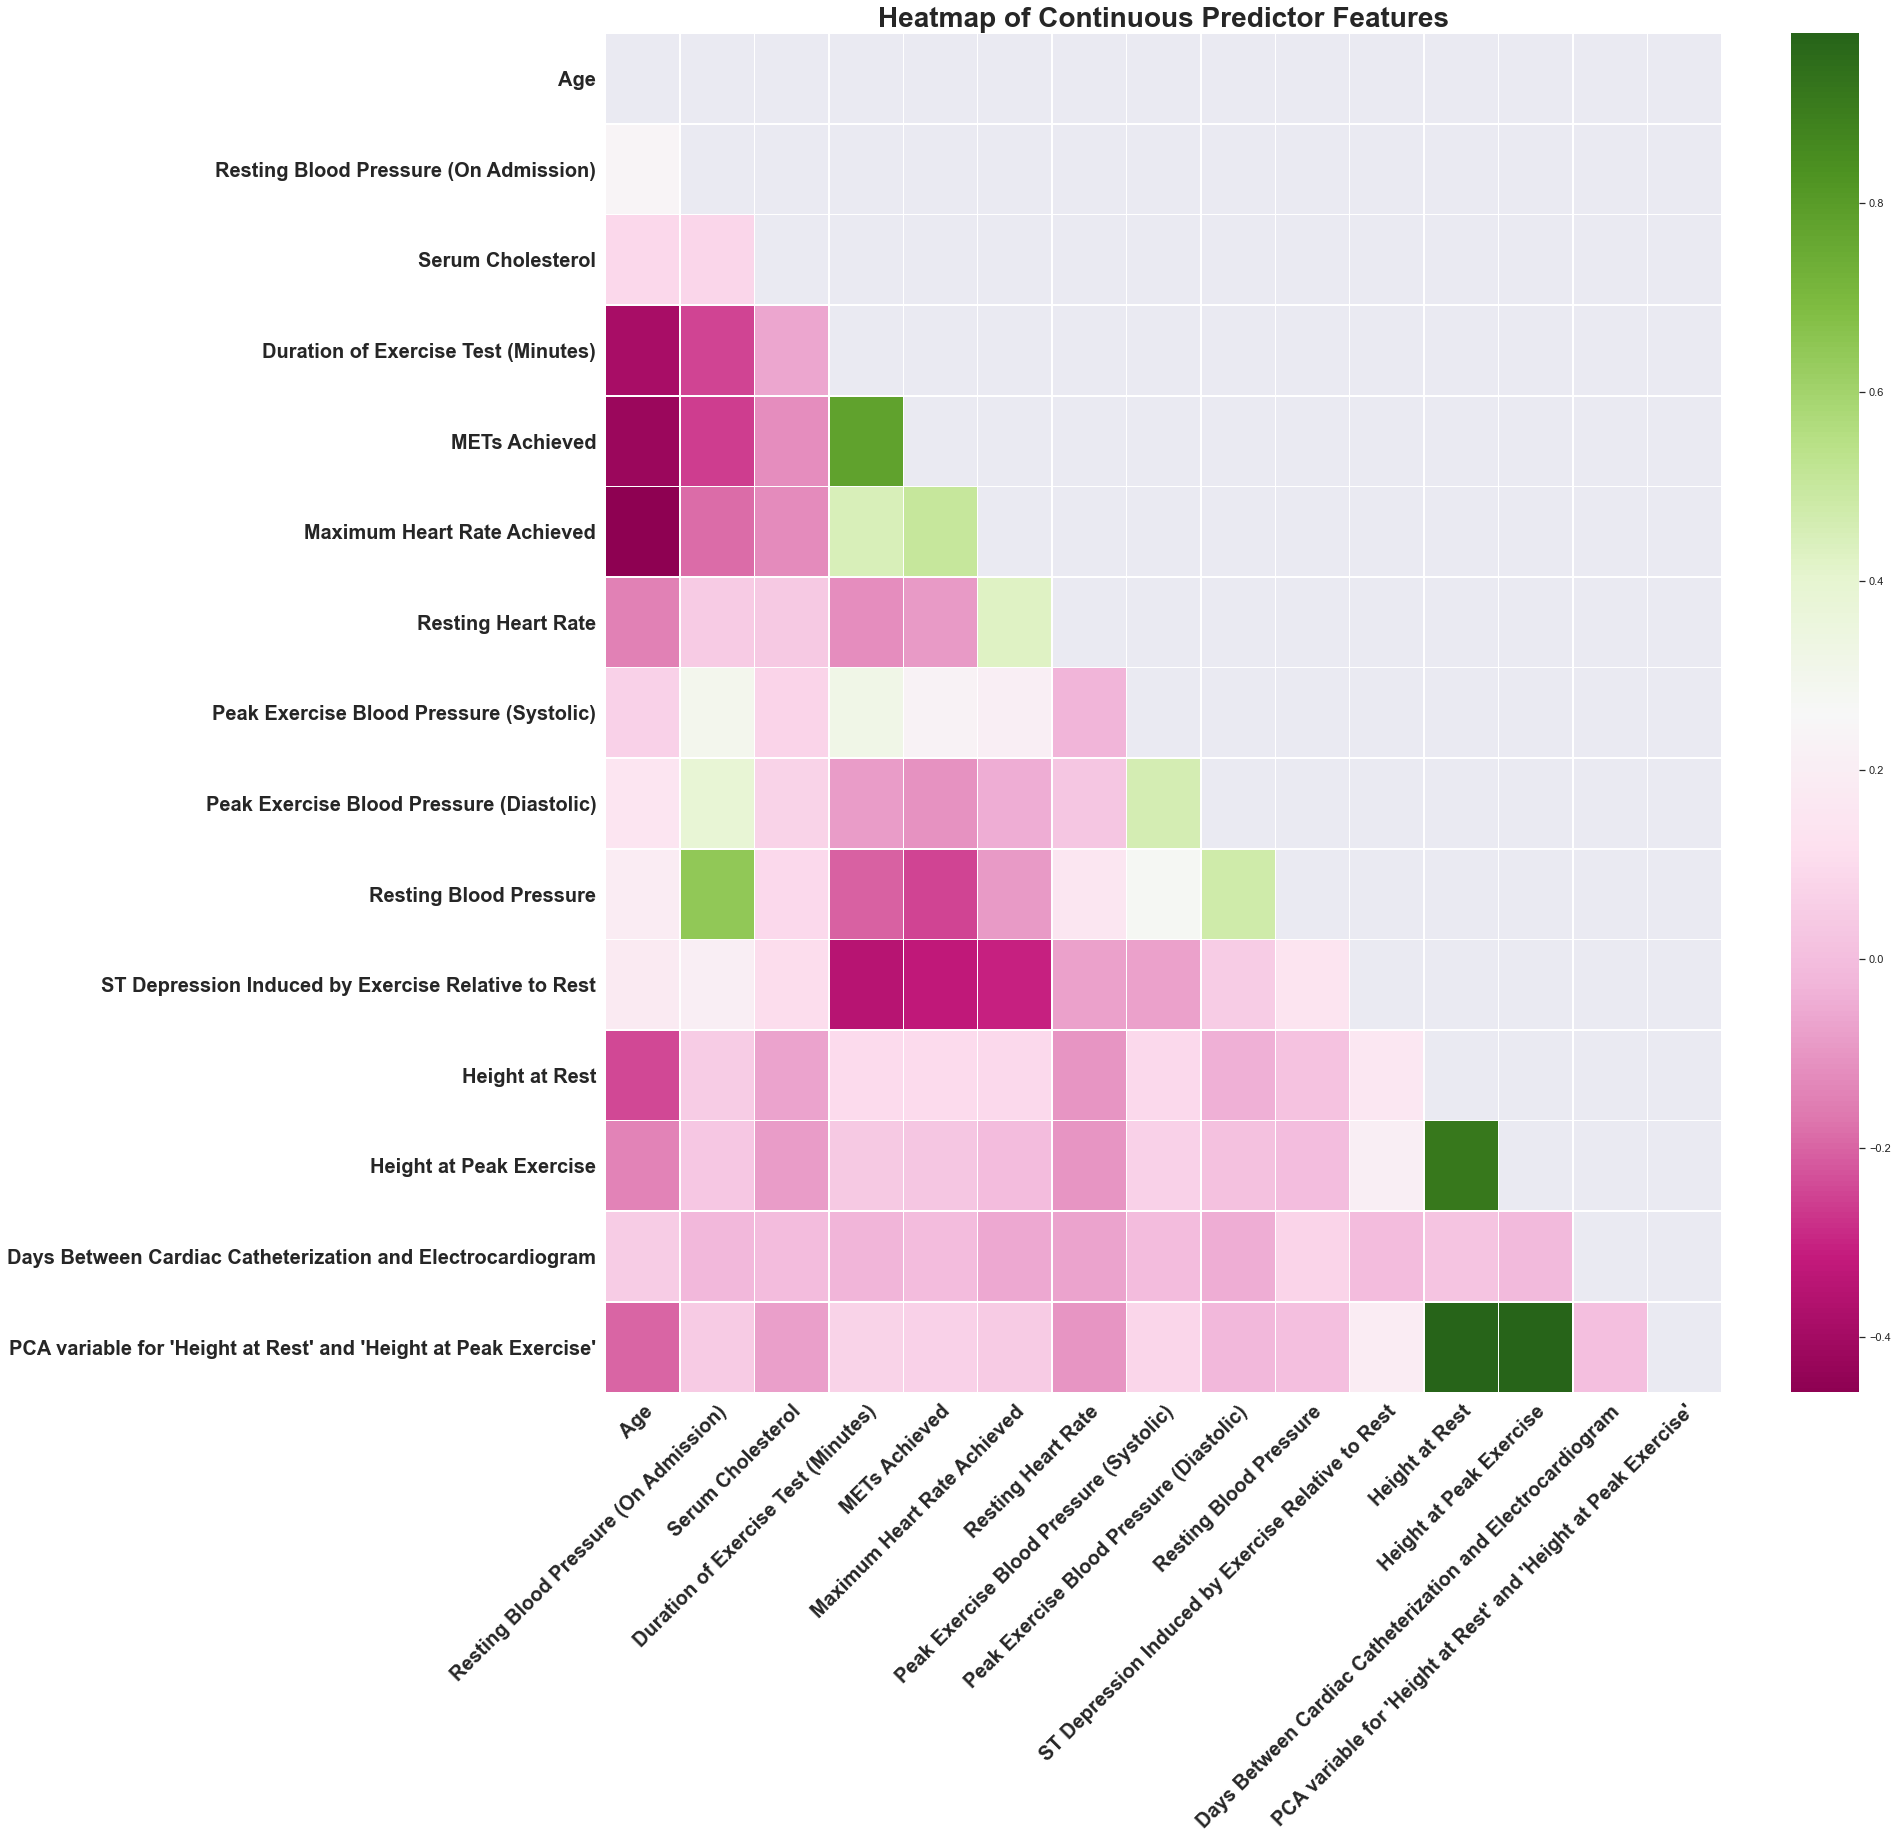

In [8]:
# Create figsize dimensions to use for plots
figsize_dimensions = (25,25)

# Heatmap of correlations
heatmap_fontsize = 20

# Only return bottom portion of heatmap as top is duplicate and diagonal is redundant
continuous_variable_correlations = hungarian[continuous_variables].corr()
# Array of zeros with same shape as continuous_variable_correlations
mask = np.zeros_like(continuous_variable_correlations)
# Mark upper half and diagonal of mask as True
mask[np.triu_indices_from(mask)] = True

# Correlation heatmap
f, ax = plt.subplots(figsize=figsize_dimensions)
ax = sns.heatmap(hungarian[continuous_variables].corr(), cmap='PiYG', mask=mask, linewidths=.5, linecolor="white",
                 cbar=True)
ax.set_xticklabels(labels=continuous_variables_spelled_out_dict.values(),fontdict ={'fontweight': 'bold', 
                                                                                    'fontsize':heatmap_fontsize},
                   rotation=45, ha="right",
                   rotation_mode="anchor")
ax.set_yticklabels(labels=continuous_variables_spelled_out_dict.values(),fontdict ={'fontweight': 'bold', 
                                                                                    'fontsize':heatmap_fontsize})
ax.set_title("Heatmap of Continuous Predictor Features", fontdict ={'fontweight': 'bold', 'fontsize': 28})

In [9]:
# Correlations > 0.6 and < 1.0 and <-0.6 and >-1.0, drop all null columns
hungarian[continuous_variables].corr()[((hungarian[continuous_variables].corr() > 0.6) &
                                              (hungarian[continuous_variables].corr() < 1.0)) |
                                             ((hungarian[continuous_variables].corr()<-0.6) &
                                              (hungarian[continuous_variables].corr()>-1.0))].dropna(axis=1, how='all')

,trestbps,thaldur,met,trestbpd,rldv5,rldv5e,rldv5_rldv5e_pca
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trestbps,NaN,NaN,NaN,0.644058,NaN,NaN,NaN
chol,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thaldur,NaN,NaN,0.780905,NaN,NaN,NaN,NaN
met,NaN,0.780905,NaN,NaN,NaN,NaN,NaN
thalach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thalrest,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tpeakbps,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tpeakbpd,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trestbpd,0.644058,NaN,NaN,NaN,NaN,NaN,NaN


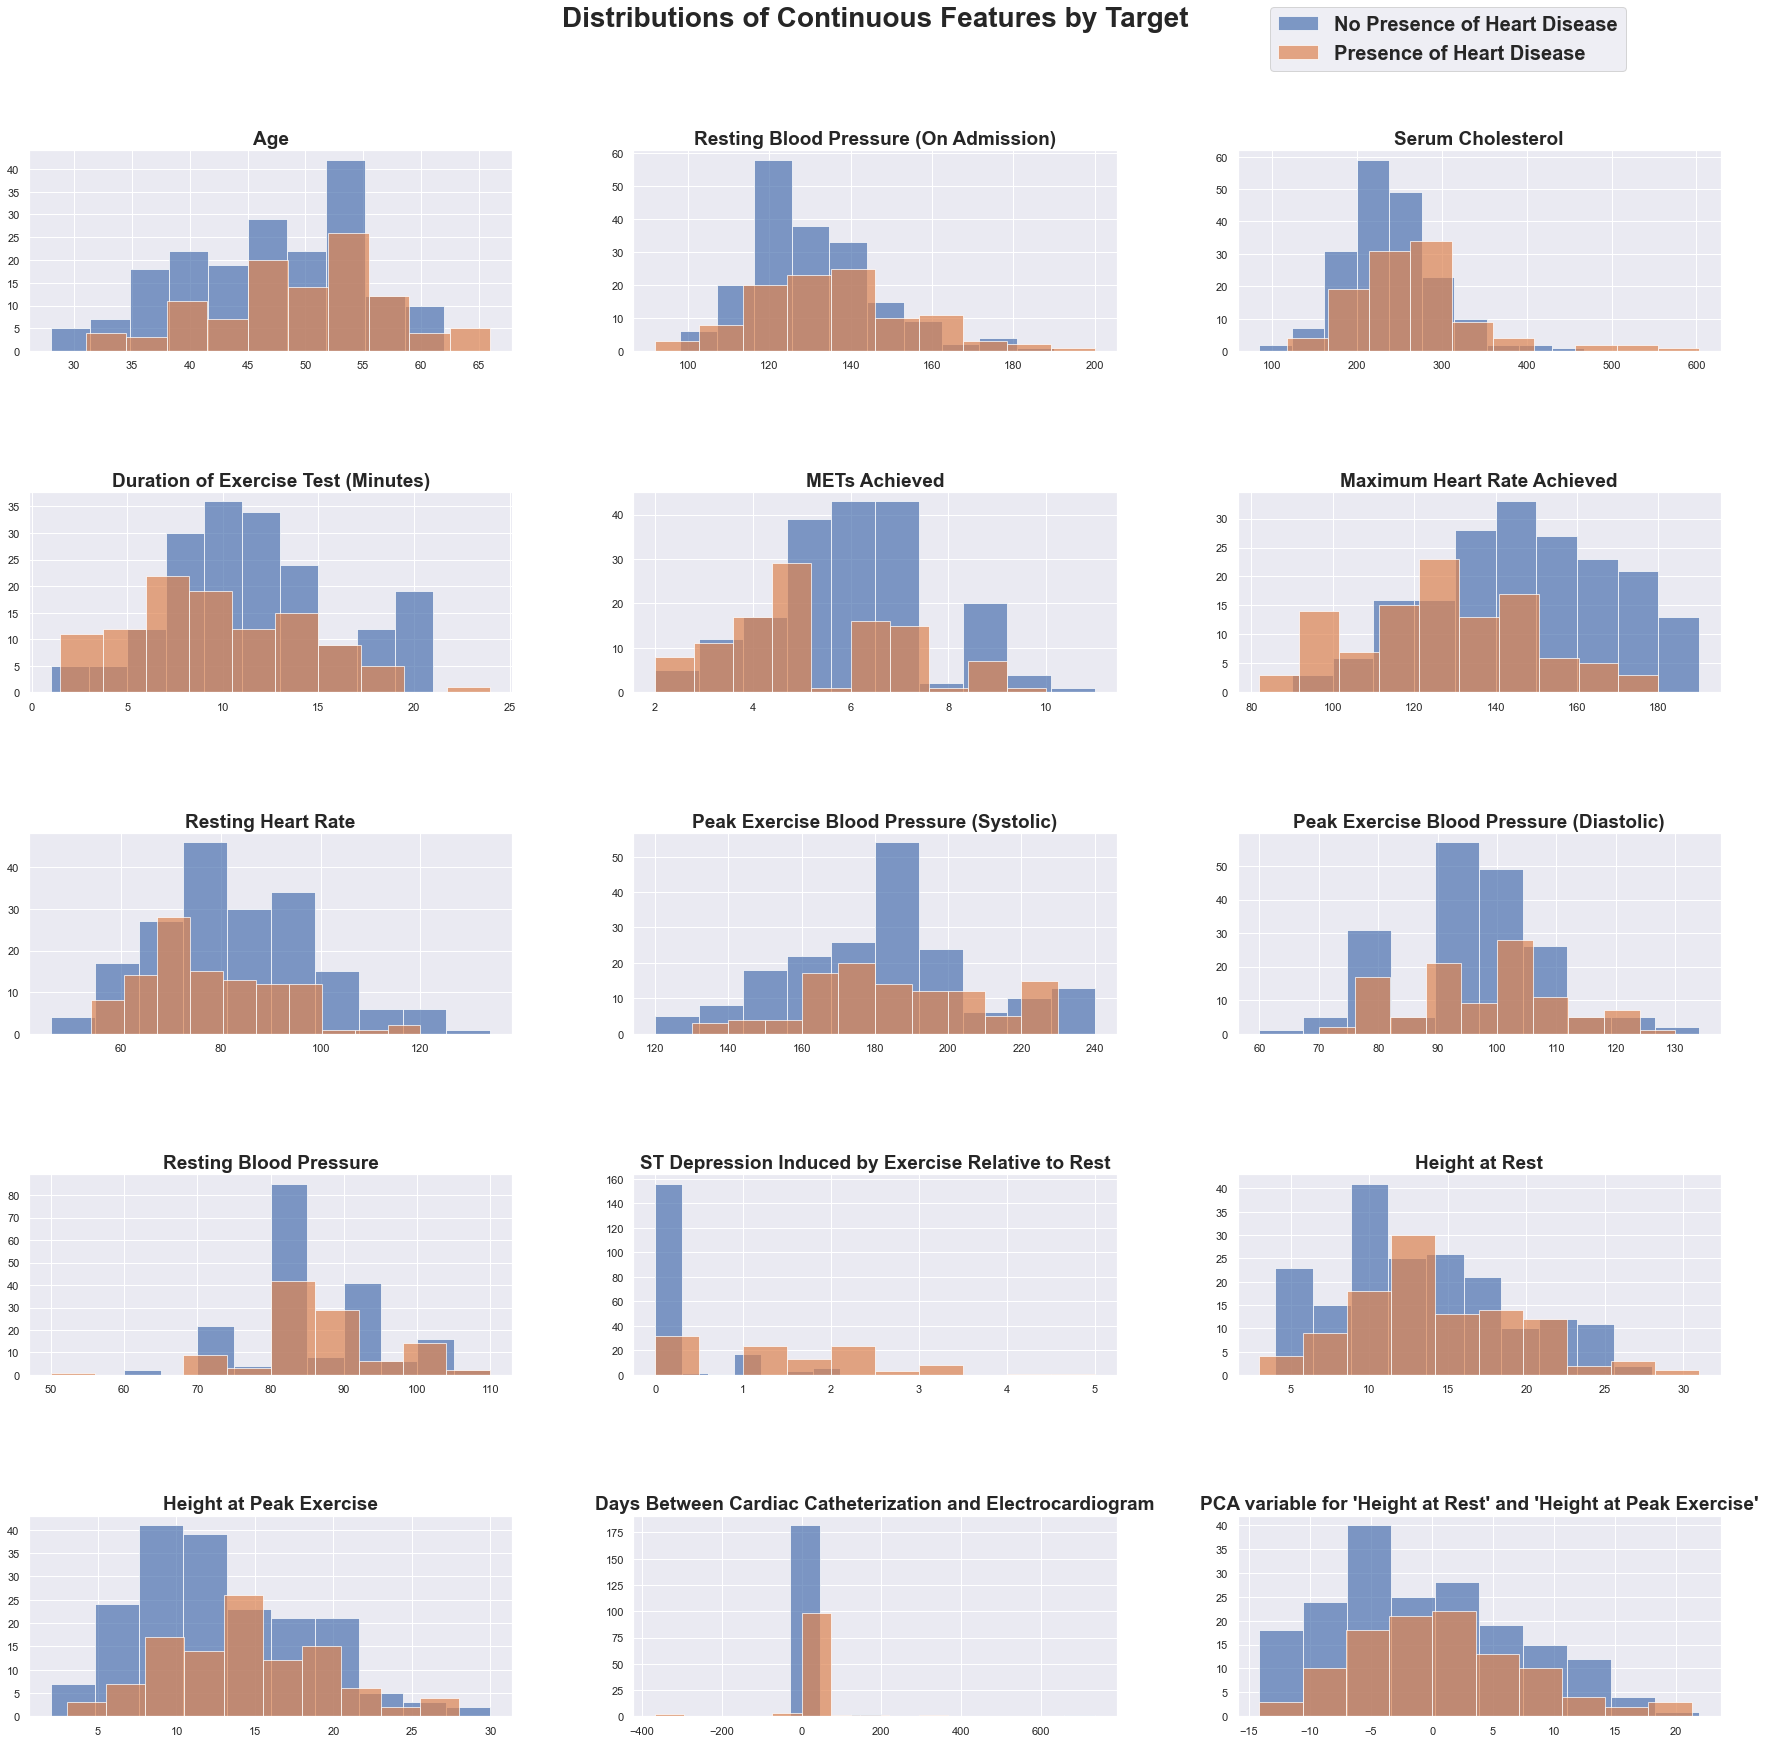

In [10]:
# Histograms for continuous variable against num
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=figsize_dimensions)
fig.subplots_adjust(left=0.03, right=.97, top=0.90, bottom=0.03, hspace=0.7, wspace=0.25)
fig.suptitle('Distributions of Continuous Features by Target', fontweight='bold', fontsize= 28)
for ax, continuous in zip(axes.flatten(), continuous_variables):
    for num_value in hungarian.num.unique():
        ax.hist(hungarian.loc[hungarian.num == num_value, continuous], alpha=0.7, label=num_value)
        ax.set_title(continuous_variables_spelled_out_dict[continuous], fontdict ={'fontweight': 'bold', 'fontsize': 19})
handles, legends = ax.get_legend_handles_labels()
legends_spelled_out_dict = {0: "No Presence of Heart Disease", 1: "Presence of Heart Disease"}
fig.legend(handles, legends_spelled_out_dict.values(), loc='upper left', bbox_to_anchor=(0.70, 0.97), prop={'weight': 'bold',
                                                                                                            'size':20})


In [11]:
### Check normality of continuous variables
for continuous in continuous_variables:
    print(continuous)
    print(f"Kurtosis value: {stats.kurtosis(a=hungarian[continuous], fisher=True)}")
    print(f"Sknewness value: {stats.skew(a=hungarian[continuous])}")
    print(f"P-value from normal test: {stats.normaltest(a=hungarian[continuous])[1]}")
    if stats.normaltest(a=hungarian[continuous])[1] < strong_alpha_value:
        print("Reject null hypothesis the samples comes from a normal distribution.")
        print("-------------------------------------------------------------------")
        try:
            print(f"Kurtosis value: {stats.kurtosis(a=stats.boxcox(x=hungarian[continuous])[0], fisher=True)}")
            print(f"Sknewness value: {stats.skew(a=stats.boxcox(x=hungarian[continuous])[0])}")
            print(f"P-value from normal test: {stats.normaltest(a=stats.boxcox(x=hungarian[continuous])[0])[1]}")
        except ValueError as a:
            if str(a) == "Data must be positive.":
                print(f"{continuous} contains zero or negative values.")
    else:
        print("Do not reject the null hypothesis")
    print('\n')
    
# Boxcox necessary variables that reject the null hypothesis from normaltest in scipy.stats
hungarian['trestbps_boxcox'] = stats.boxcox(x=hungarian.trestbps)[0]
hungarian['chol_boxcox'] = stats.boxcox(x=hungarian.chol)[0]
hungarian['thalrest_boxcox'] = stats.boxcox(x=hungarian.thalrest)[0]

# Add boxcox'd variables to continuous_variables_spelled_out_dict
for boxcox_var in filter(lambda x: '_boxcox' in x, hungarian.columns):
    continuous_variables_spelled_out_dict[boxcox_var] = continuous_variables_spelled_out_dict[
                                                            boxcox_var.split("_")[0]] + " Box-Cox"

age
Kurtosis value: -0.5251244963052026
Sknewness value: -0.2760977834056663
P-value from normal test: 0.009976556514402634
Do not reject the null hypothesis


trestbps
Kurtosis value: 0.795367670185823
Sknewness value: 0.7437845205687135
P-value from normal test: 6.765682640107371e-07
Reject null hypothesis the samples comes from a normal distribution.
-------------------------------------------------------------------
Kurtosis value: 0.10124519999116588
Sknewness value: -0.002422443274683635
P-value from normal test: 0.858823606180114


chol
Kurtosis value: 5.0883075112157385
Sknewness value: 1.5157747461005682
P-value from normal test: 6.4904000738594354e-24
Reject null hypothesis the samples comes from a normal distribution.
-------------------------------------------------------------------
Kurtosis value: 2.1898023368129858
Sknewness value: -0.00030431174018865124
P-value from normal test: 8.54004651141889e-05


thaldur
Kurtosis value: -0.4394294179853637
Sknewness value: 0.24486

AxesSubplot(0.05,0.04;0.427273x0.86) chol
AxesSubplot(0.562727,0.04;0.427273x0.86) chol_boxcox


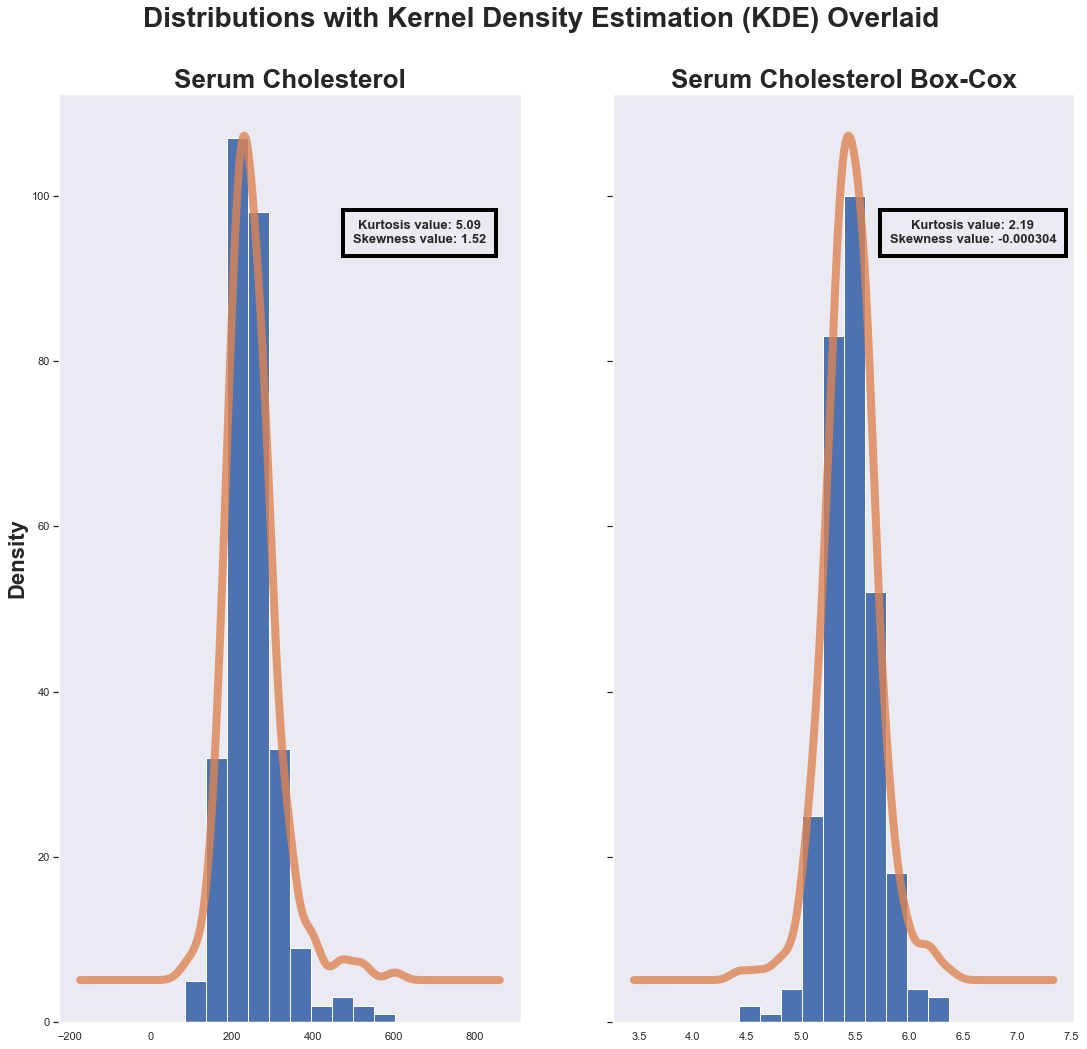

In [13]:
# Compare original distribution with boxcox'd distribution for chol
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,15))
fig.subplots_adjust(left=0.05, right=.99, top=0.90, bottom=0.04)
fig.suptitle('Distributions with Kernel Density Estimation (KDE) Overlaid ', fontweight='bold', fontsize=28)
for ax, variable in zip(axes.flatten(), ['chol', 'chol_boxcox']):
    print(ax, variable)
    ax.hist(hungarian[variable])
    ax2 = hungarian[variable].plot.kde(ax=ax, secondary_y=True, linewidth=8, alpha=0.8)
    ax2.grid(False)
    ax2.set_yticks([])
    ax2.set_title(continuous_variables_spelled_out_dict[variable], fontdict={'fontweight': 'bold', 'fontsize': 26})
    ax.text(0.78, 0.85, f"Kurtosis value: {'{:.3}'.format(stats.kurtosis(a=hungarian[variable], fisher=True))}\n"
                      f"Skewness value: {'{:.3}'.format(stats.skew(a=hungarian[variable]))}",
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,
            bbox=dict(facecolor='none', edgecolor='black', pad=10.0, linewidth=4), weight='bold', fontsize=13)
    ax.set_ylabel('Density', fontdict={'fontweight': 'bold', 'fontsize': 22})

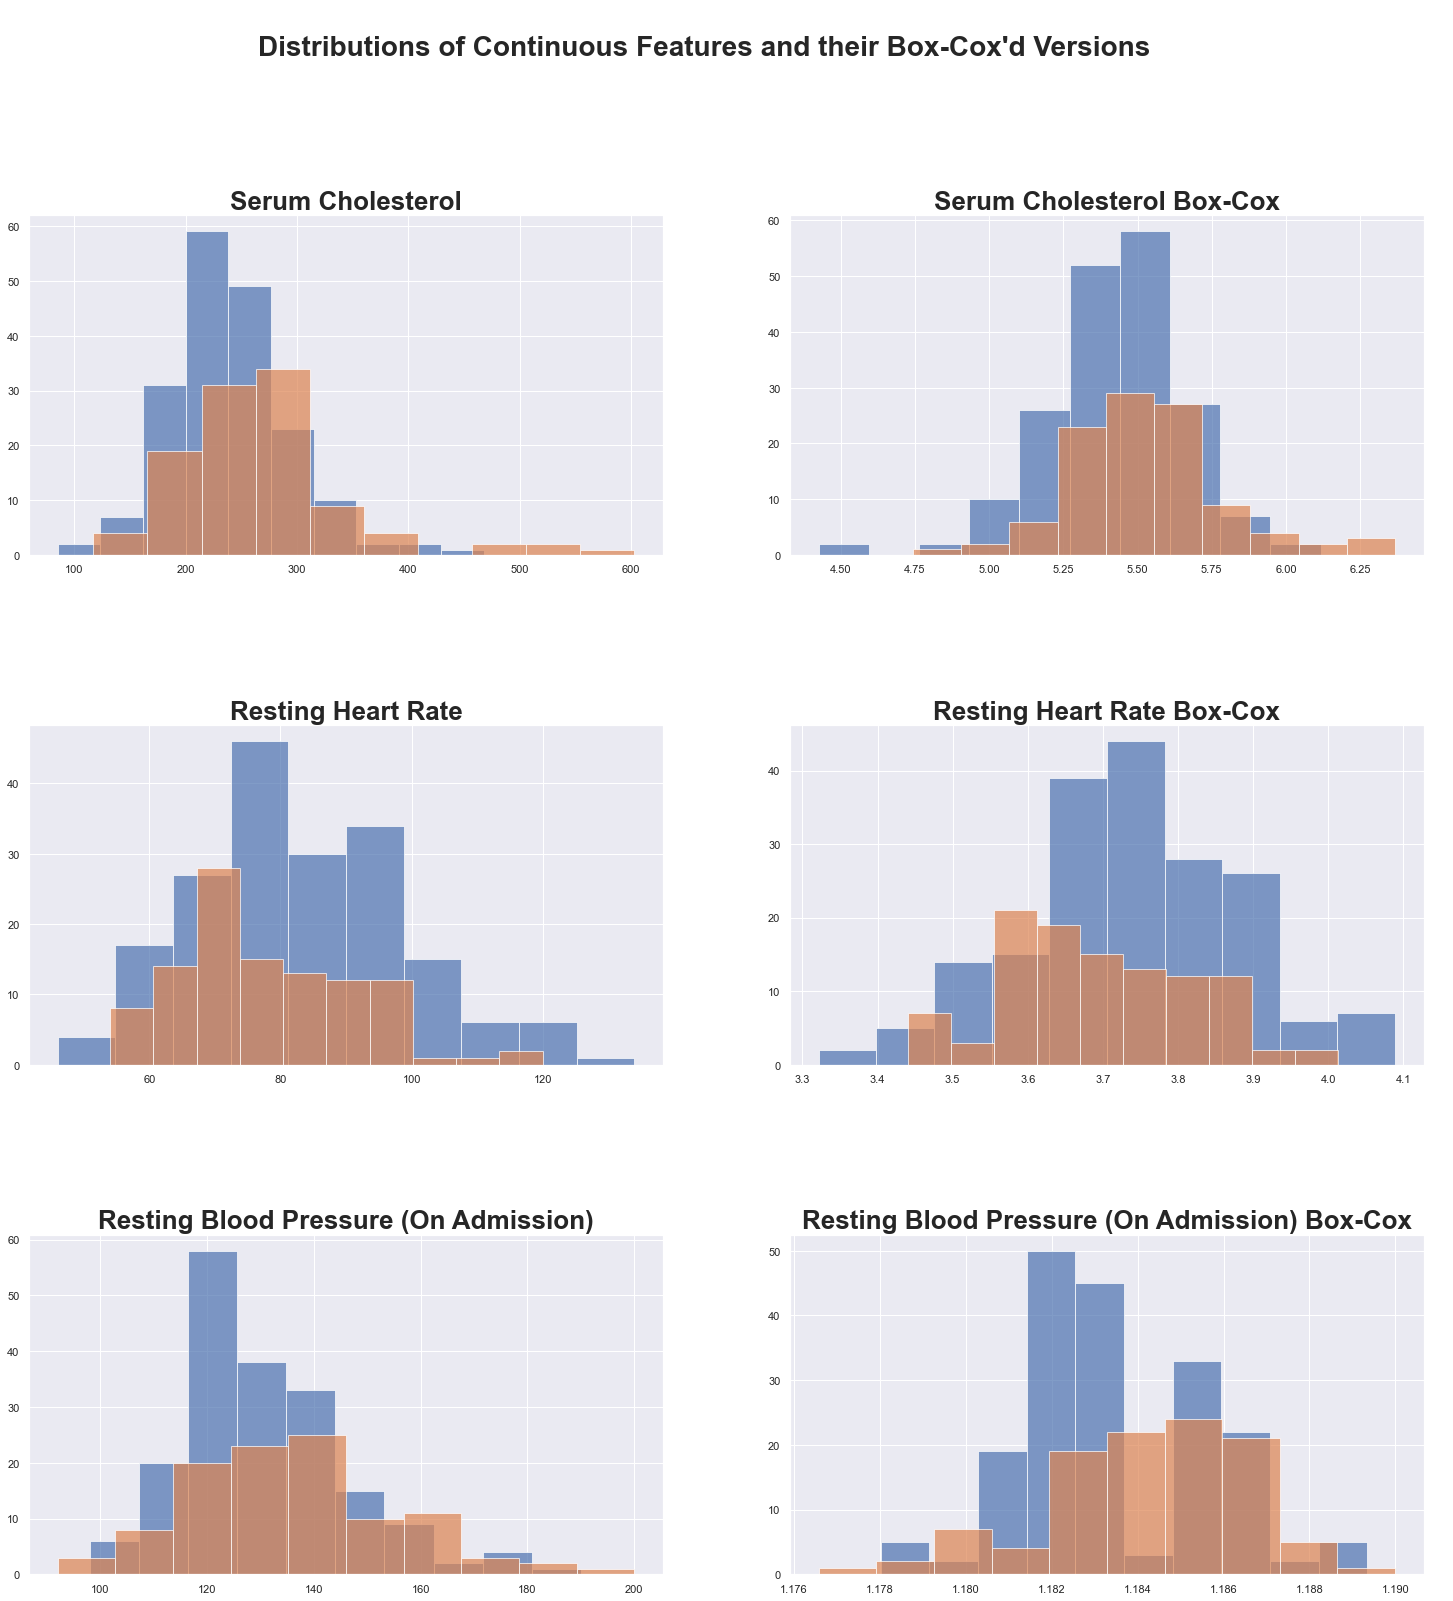

In [15]:
# Plot original and boxcox'd distributions to each other and against num
# Create list of boxcox'd variables and their originals
variables_for_inspection = list(itertools.chain.from_iterable([[x, x.split("_")[0]] for x in list(hungarian) if 'boxcox' in x]))
# Sort list in ascending order
variables_for_inspection.sort(reverse=False)
fig, axes = plt.subplots(nrows=len([x for x in variables_for_inspection if 'boxcox' in x]), ncols=2, figsize=figsize_dimensions)
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Distributions of Continuous Features and their Box-Cox'd Versions", fontweight='bold', fontsize=28)
for ax, variable in zip(axes.flatten(), variables_for_inspection):
    for num_value in hungarian.num.unique():
        ax.hist(hungarian.loc[hungarian.num == num_value, variable], alpha=0.7, label=num_value)
        ax.set_title(continuous_variables_spelled_out_dict[variable], fontdict={'fontweight': 'bold', 'fontsize': 26})
handles, legends = ax.get_legend_handles_labels()
legends_spelled_out_dict = {0: "No Presence of Heart Disease", 1: "Presence of Heart Disease"}
fig.legend(handles, legends_spelled_out_dict.values(), loc='upper left', bbox_to_anchor=(0.77, 1.0),
           prop={'weight': 'bold', 'size': 14})

In [16]:
# Pearson chi-square tests
chi_square_analysis_list = []
for categorical in categorical_variables:
    chi, p, dof, expected = stats.chi2_contingency(pd.crosstab(index=hungarian[categorical], columns=hungarian[target_variable]))
    print(f"The chi-square value for {categorical} and {target_variable} is {chi}, and the p-value is" f" {p}, respectfully.")
    print('\n')
    chi_square_analysis_list.append([categorical, target_variable, chi, p])

# Create DataFrame from lists of lists
chi_square_analysis_df = pd.DataFrame(chi_square_analysis_list, columns=['variable', 'target', 'chi',
                                                            'p_value']).sort_values(by='p_value', ascending=True)
# Determine categorical variables that reject null
print(chi_square_analysis_df.loc[chi_square_analysis_df.p_value <= strong_alpha_value])

The chi-square value for sex and num is 19.641611881165147, and the p-value is 9.341248489060121e-06, respectfully.


The chi-square value for painloc and num is 2.5838848346862147, and the p-value is 0.1079564166907364, respectfully.


The chi-square value for painexer and num is 83.46039138482502, and the p-value is 6.50054702954124e-20, respectfully.


The chi-square value for relrest and num is 56.91079754672746, and the p-value is 4.560350622794233e-14, respectfully.


The chi-square value for cp and num is 94.44665445592759, and the p-value is 2.4278973764043244e-20, respectfully.


The chi-square value for htn and num is 3.545691478256375, and the p-value is 0.05970027878074344, respectfully.


The chi-square value for fbs and num is 6.373059951308582, and the p-value is 0.01158656359926162, respectfully.


The chi-square value for restecg and num is 1.0291982784661928, and the p-value is 0.5977401571772292, respectfully.


The chi-square value for prop and num is 5.157584255127

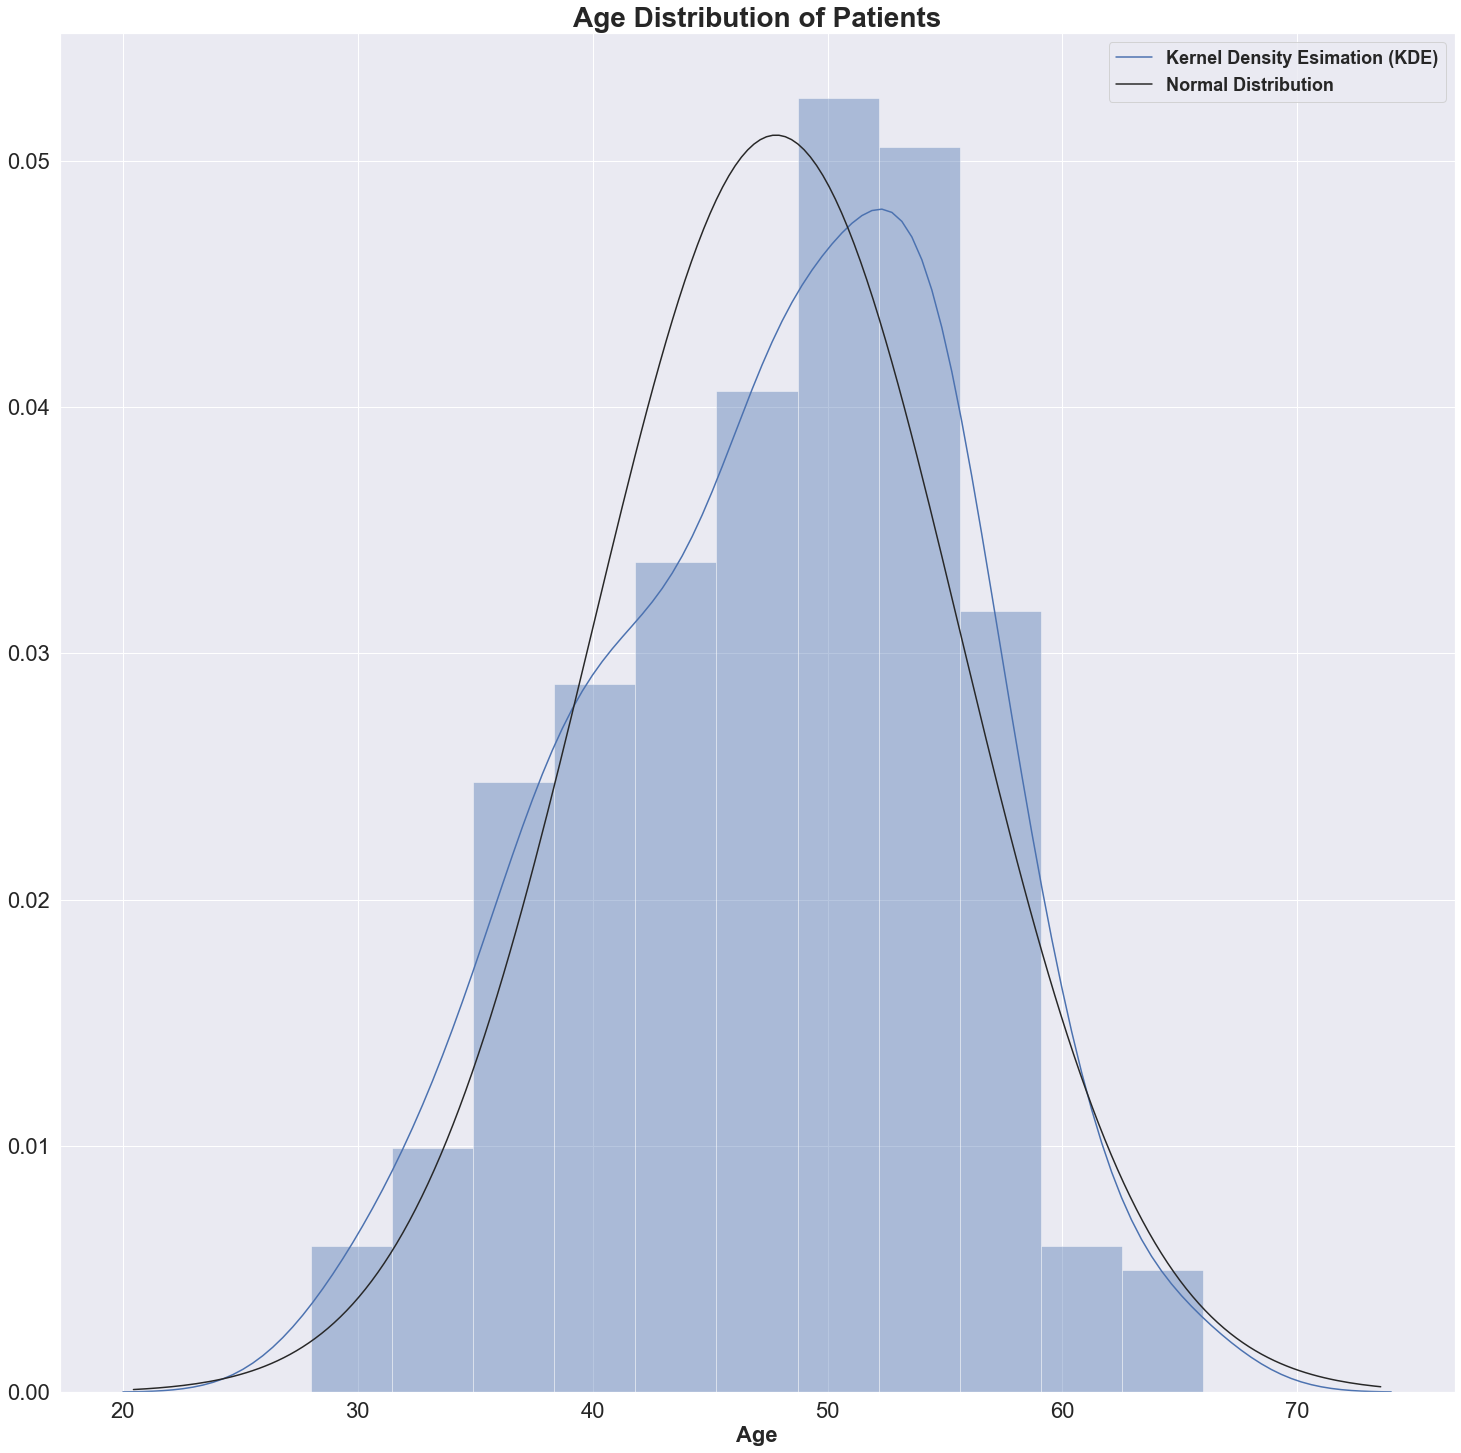

Mean +/- std of age: 47.8 +/ 7.83. This means 68% of my patients lie between the ages of 39.97 and 55.64.
Mean +/- 2 std of age: 47.8 +/ 15.66. This means 95% of my patients lie between the ages of 32.14 and 63.47.
Mean +/- 3 std of age: 47.8 +/ 23.49. This means 99.7% of my patients lie between the ages of 24.31 and 71.3.
Mode of age: 54
Median of age: 49.0


In [17]:
# Set parameters for distplots and countplots
title_fontsize, font_size_label_size, legend_size = 28, 22, 18


# Crosstab of age and num
pd.crosstab(index=hungarian.age,columns=hungarian.num, normalize=True)

# Distribution plot of age of all patients
plt.figure(figsize=figsize_dimensions)
ax = sns.distplot(hungarian['age'], kde=True, fit=stats.norm, rug=False,
             kde_kws={"label": "Kernel Density Esimation (KDE)"},
             fit_kws={"label": "Normal Distribution"})
ax.set_title("Age Distribution of Patients", fontdict ={'fontweight': 'bold', 'fontsize': title_fontsize})
ax.set_xlabel('Age', fontdict={'fontweight': 'bold', 'fontsize': font_size_label_size})
ax.xaxis.set_tick_params(labelsize=font_size_label_size)
ax.yaxis.set_tick_params(labelsize=font_size_label_size)

plt.legend(loc='best', prop={'weight': 'bold', 'size': legend_size})
plt.show()

# Statistical understanding of age of all patients
print(f"Mean +/- std of {hungarian['age'].name}: {round(hungarian['age'].describe()['mean'],2)} +/"
      f" {round(hungarian['age'].describe()['std'],2)}. This means 68% of my patients lie between the ages of"
      f" {round(hungarian['age'].describe()['mean'] - hungarian['age'].describe()['std'],2)} and"
      f" {round(hungarian['age'].describe()['mean'] + hungarian['age'].describe()['std'],2)}.")
standard_devations = 2
print(f"Mean +/- {standard_devations} std of {hungarian['age'].name}: {round(hungarian['age'].describe()['mean'],2)} +/"
      f" {round(hungarian['age'].describe()['std'] * standard_devations,2)}. This means 95% of my patients lie between the ages of"
      f" {round(hungarian['age'].describe()['mean'] - (standard_devations * hungarian['age'].describe()['std']),2)} and"
      f" {round(hungarian['age'].describe()['mean'] + (standard_devations * hungarian['age'].describe()['std']),2)}.")
standard_devations = 3
print(f"Mean +/- {standard_devations} std of {hungarian['age'].name}: {round(hungarian['age'].describe()['mean'],2)} +/"
      f" {round(hungarian['age'].describe()['std'] * standard_devations,2)}. This means 99.7% of my patients lie between the ages of"
      f" {round(hungarian['age'].describe()['mean'] - (standard_devations * hungarian['age'].describe()['std']),2)} and"
      f" {round(hungarian['age'].describe()['mean'] + (standard_devations * hungarian['age'].describe()['std']),2)}.")
print(f"Mode of {hungarian['age'].name}: {hungarian['age'].mode()[0]}\nMedian of {hungarian['age'].name}: {hungarian['age'].median()}")

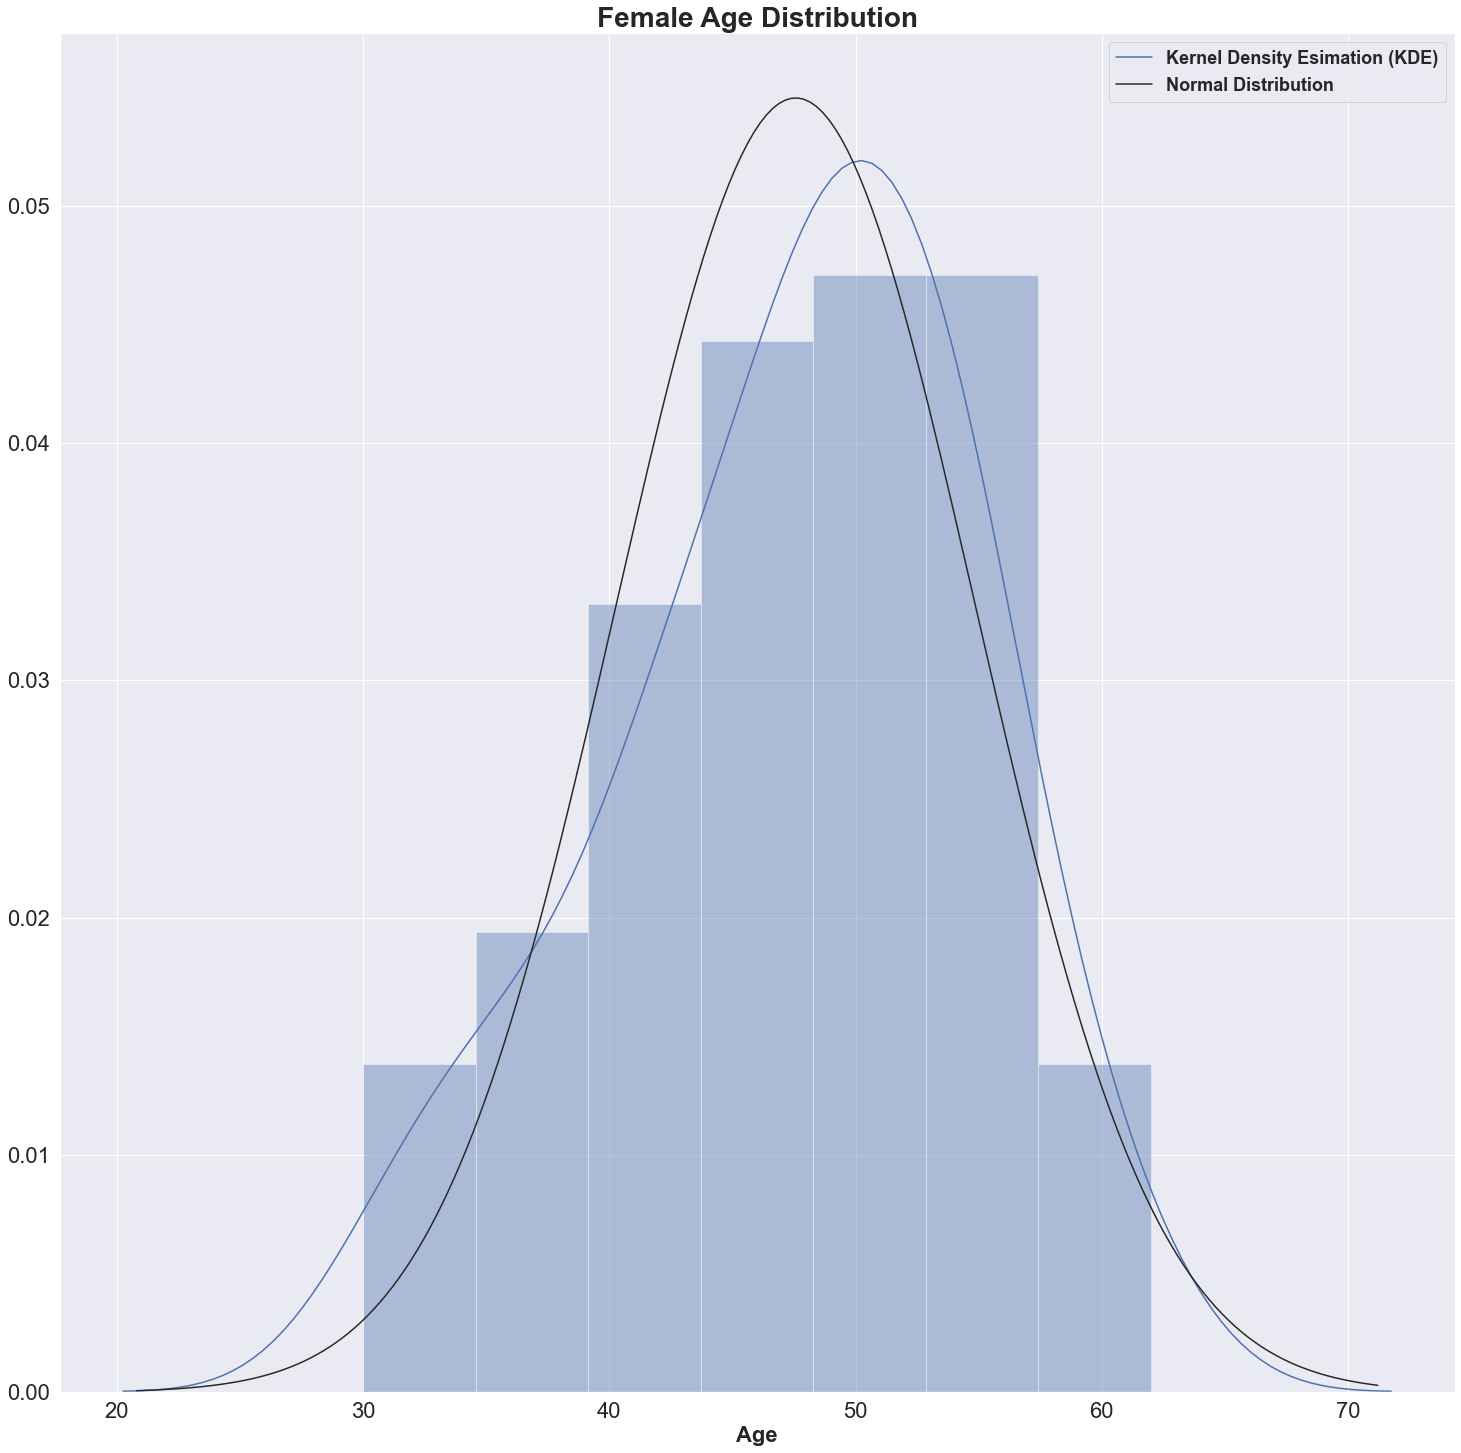

Mean +/- std of age for women: 47.57 +/ 7.36
Mode of age for women: 43
Median of age for women: + 48.0




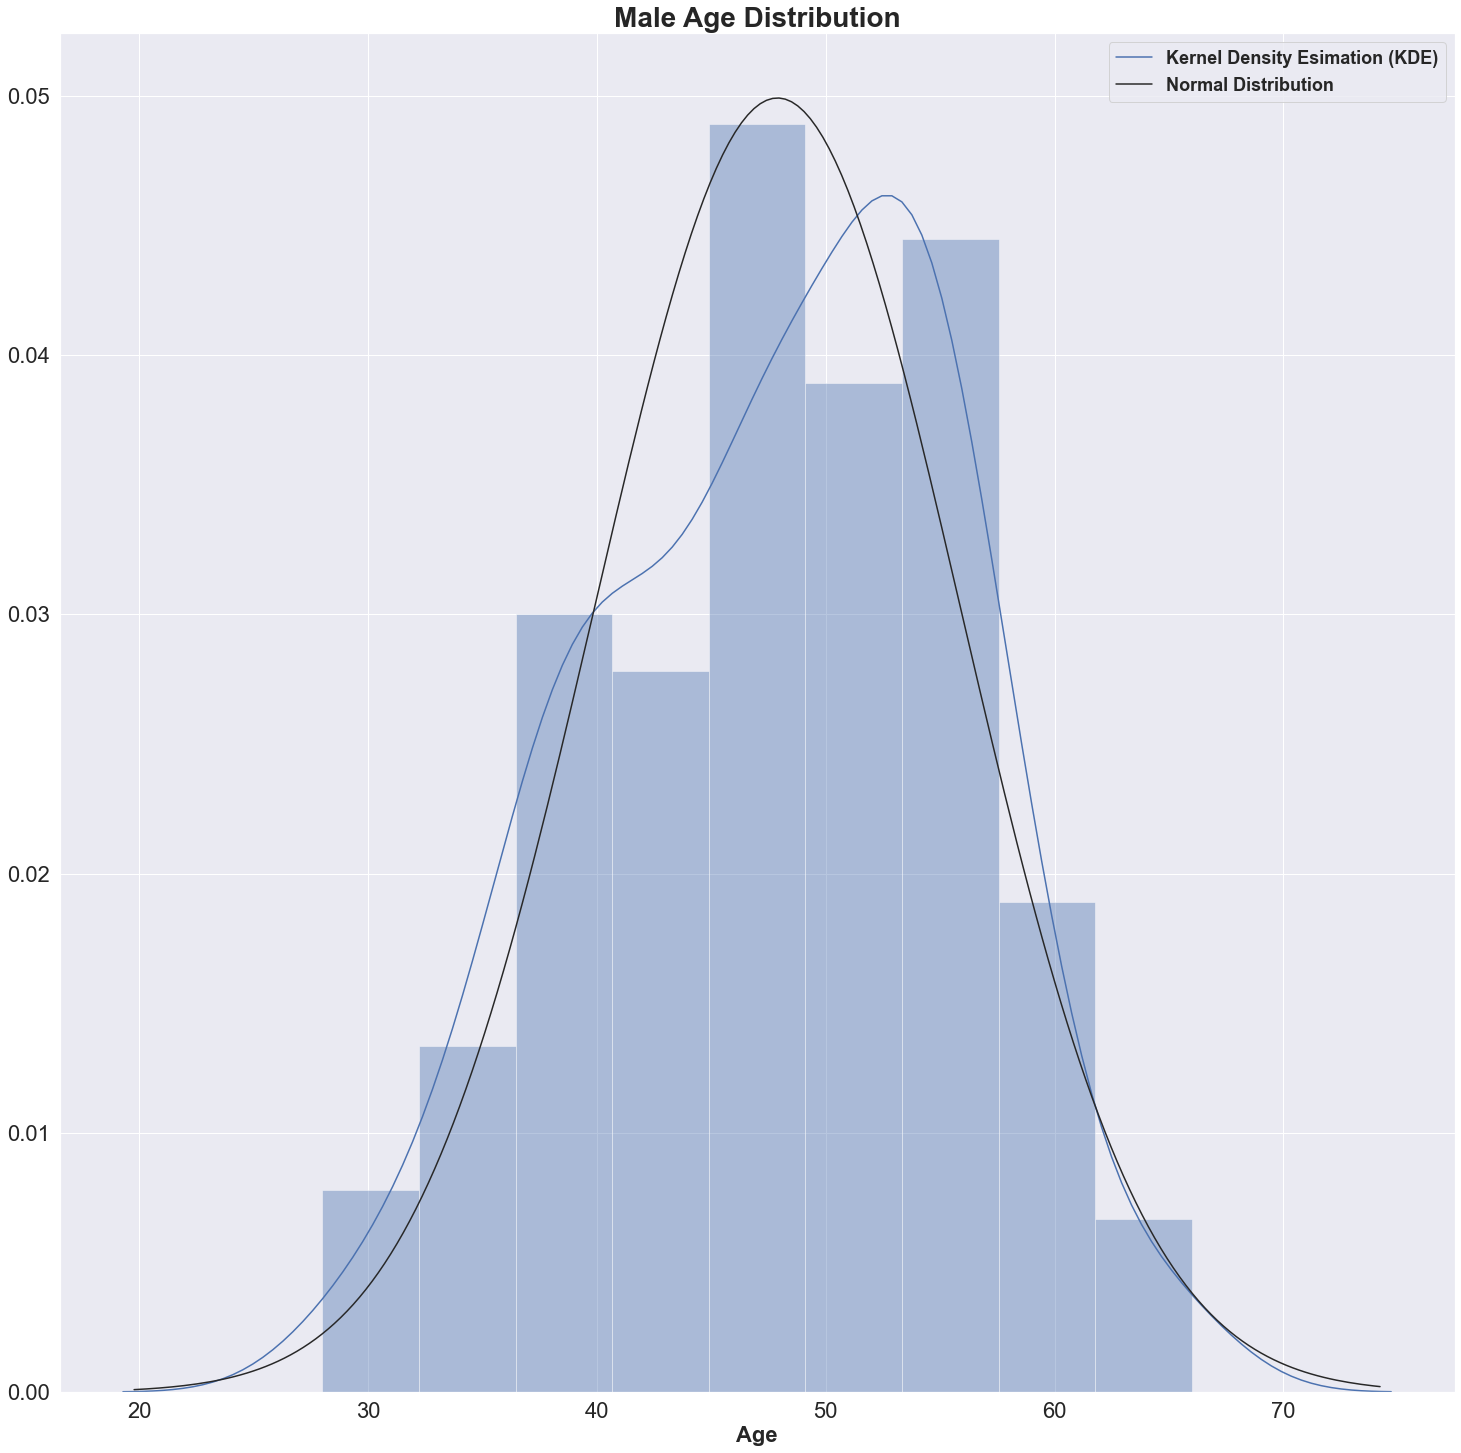

Mean +/- std of age for men: 47.89 +/ 8.01
Mode of age for men: 54
Median of age for men: + 49.0


In [19]:
# Distribution plot of age of patients broken down by sex - female
plt.figure(figsize=figsize_dimensions)
ax = sns.distplot(hungarian.loc[hungarian['sex']==0, 'age'], kde=True, fit=stats.norm,
             kde_kws={"label": "Kernel Density Esimation (KDE)"},
             fit_kws={"label": "Normal Distribution"})
ax.set_title('Female Age Distribution', fontdict ={'fontweight': 'bold', 'fontsize': title_fontsize})
ax.set_xlabel('Age', fontdict={'fontweight': 'bold', 'fontsize': font_size_label_size})
ax.xaxis.set_tick_params(labelsize=font_size_label_size)
ax.yaxis.set_tick_params(labelsize=font_size_label_size)
plt.legend(loc='best', prop={'weight': 'bold', 'size': legend_size})
plt.show()

# Women age information
print(f"Mean +/- std of {hungarian.loc[hungarian['sex']==0, 'age'].name} for women: "
      f"{round(hungarian.loc[hungarian['sex']==0, 'age'].describe()['mean'],2)} +/ "
      f"{round(hungarian.loc[hungarian['sex']==0, 'age'].describe()['std'],2)}")

print(f"Mode of {hungarian.loc[hungarian['sex']==0, 'age'].name} for women: "
      f"{hungarian.loc[hungarian['sex']==0, 'age'].mode()[0]}\nMedian of "
      f"{hungarian.loc[hungarian['sex']==0, 'age'].name} for women: + "
      f"{hungarian.loc[hungarian['sex']==0, 'age'].median()}")
print('\n')

# Distribution plot of age of patients broken down by sex - male
plt.figure(figsize=figsize_dimensions)
ax = sns.distplot(hungarian.loc[hungarian['sex']==1, 'age'],kde=True, fit=stats.norm,
             kde_kws={"label": "Kernel Density Esimation (KDE)"},
             fit_kws={"label": "Normal Distribution"})
ax.set_title('Male Age Distribution', fontdict ={'fontweight': 'bold', 'fontsize': title_fontsize})
ax.set_xlabel('Age', fontdict={'fontweight': 'bold', 'fontsize': font_size_label_size})
ax.xaxis.set_tick_params(labelsize=font_size_label_size)
ax.yaxis.set_tick_params(labelsize=font_size_label_size)
plt.legend(loc='best', prop={'weight': 'bold', 'size': legend_size})
plt.show()

# Men age information
print(f"Mean +/- std of {hungarian.loc[hungarian['sex']==1, 'age'].name} for men: "
      f"{round(hungarian.loc[hungarian['sex']==1, 'age'].describe()['mean'],2)} +/ "
      f"{round(hungarian.loc[hungarian['sex']==1, 'age'].describe()['std'],2)}")

print(f"Mode of {hungarian.loc[hungarian['sex']==1, 'age'].name} for men: "
      f"{hungarian.loc[hungarian['sex']==1, 'age'].mode()[0]}\nMedian of "
      f"{hungarian.loc[hungarian['sex']==1, 'age'].name} for men: + "
      f"{hungarian.loc[hungarian['sex']==1, 'age'].median()}")


1    213
0     79
Name: sex, dtype: int64
The hungarian dataset consists of 79 females and 213 males.


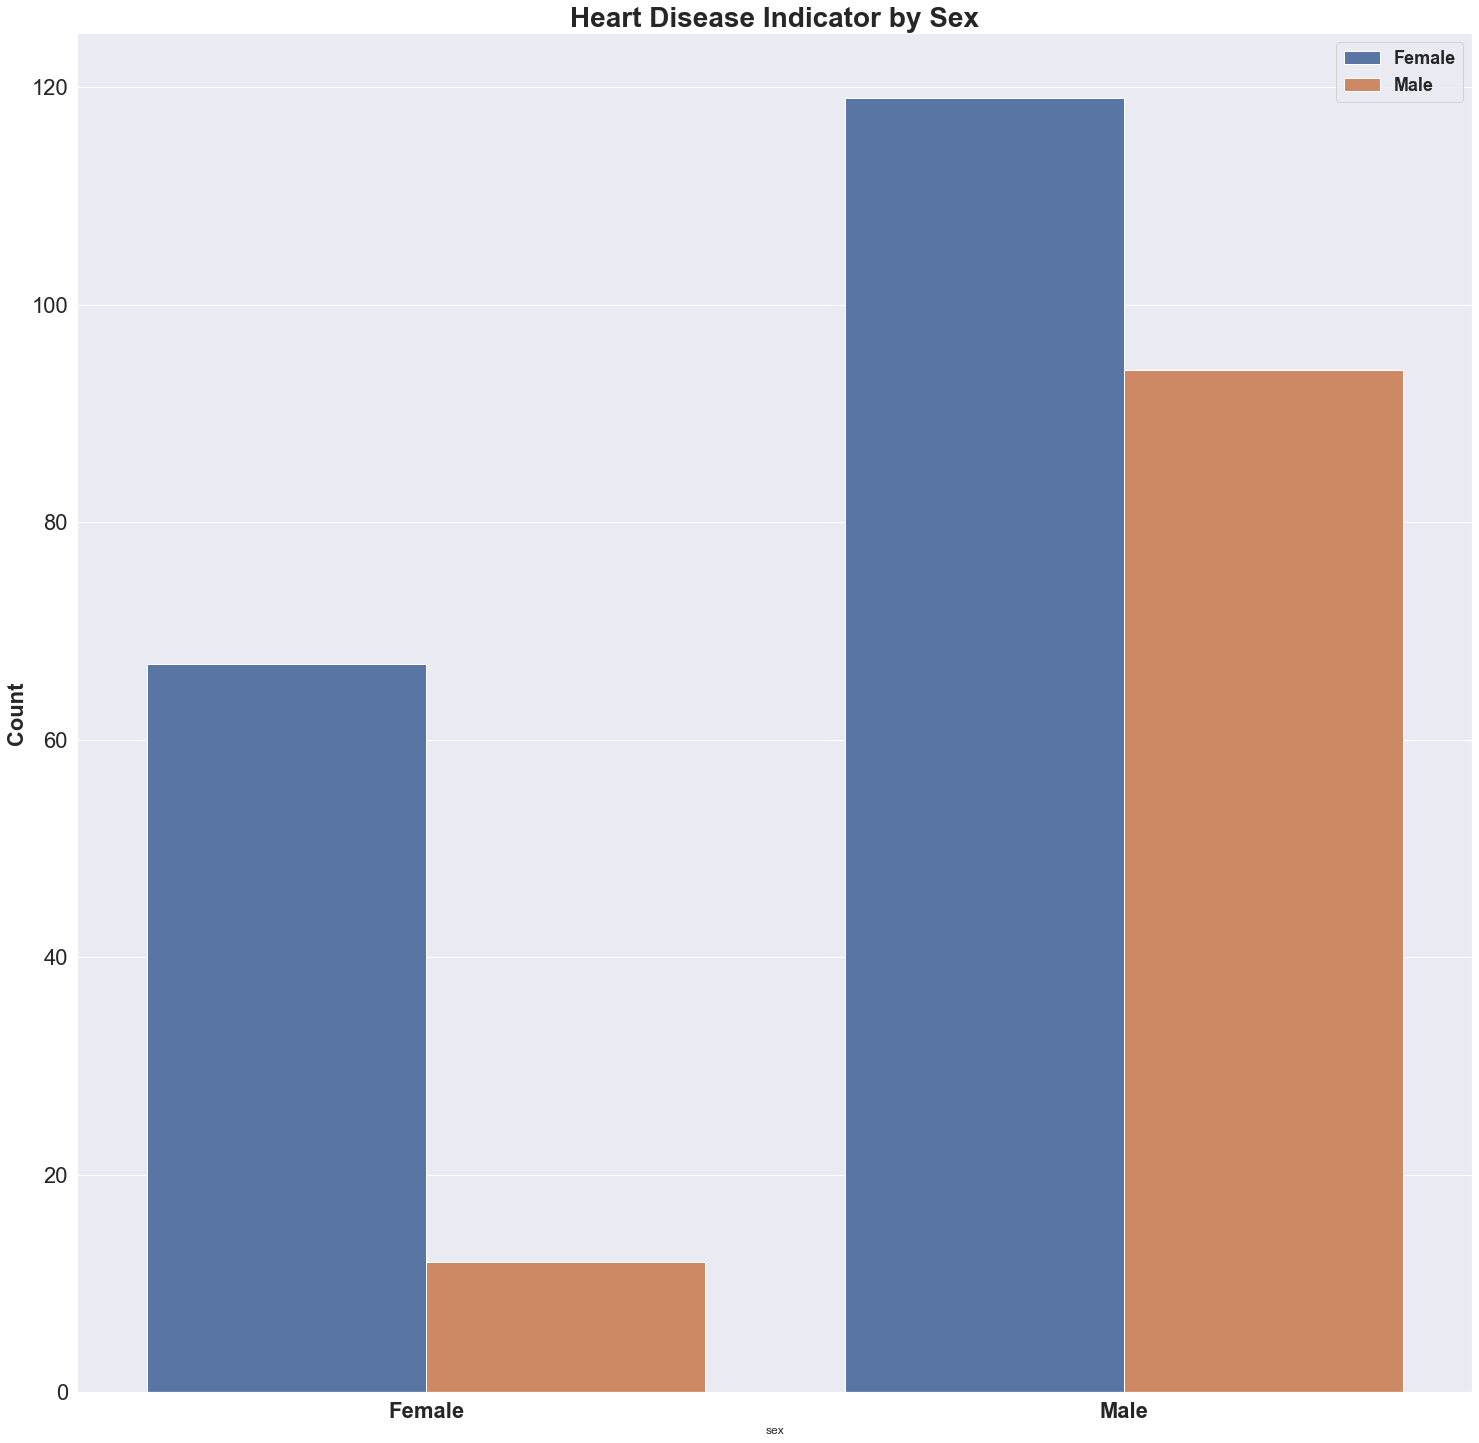

num    0   1
sex         
0     67  12
1    119  94
num         0         1
sex                    
0    0.229452  0.041096
1    0.407534  0.321918
num         0         1
sex                    
0    0.848101  0.151899
1    0.558685  0.441315
num         0         1
sex                    
0    0.360215  0.113208
1    0.639785  0.886792
num    0   1
sex         
0     67  12
1    119  94
Reject the null hypothesis of no association between sex and diagnosis of heart disease and conclude there is an association between sex and diagnosis of heart disease. The probability of a heart disease diagnosis is not the same for male and female patients.
               Estimate   SE   LCB   UCB  p-value
-------------------------------------------------
Odds ratio        4.410       2.254 8.630   0.000
Log odds ratio    1.484 0.342 0.813 2.155   0.000
Risk ratio        1.518       1.305 1.766   0.000
Log risk ratio    0.417 0.077 0.266 0.569   0.000
------------------------------------------------

In [25]:
## Sex
# Get counts of sex
print(hungarian.sex.value_counts())
print(f'The hungarian dataset consists of {hungarian.sex.value_counts()[0]} females and'
      f' {hungarian.sex.value_counts()[1]} males.')

# Bar graph of sex by num
plt.figure(figsize=figsize_dimensions)
sex_dict = {0: "Female", 1: "Male"}
ax = sns.countplot(x="sex", hue="num", data=hungarian)
ax.set_title('Heart Disease Indicator by Sex', fontdict ={'fontweight': 'bold', 'fontsize': title_fontsize})
ax.set(xticklabels=sex_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=font_size_label_size)
ax.yaxis.set_tick_params(labelsize=font_size_label_size)
ax.set_ylabel('Count', fontdict={'fontweight': 'bold', 'fontsize': font_size_label_size})
handles, legends = ax.get_legend_handles_labels()
plt.legend(handles,sex_dict.values(), loc='best', prop={'weight': 'bold', 'size': legend_size})
plt.show()

# Crosstab of sex by num
print(pd.crosstab(index=hungarian.sex, columns=hungarian.num))

# Crosstab of sex by num - all values normalized
# Of all patients in dataset, 32% were males that had heart disease. 4% were females that had heart disease.
print(pd.crosstab(index=hungarian.sex, columns=hungarian.num, normalize='all'))

# Crosstab of sex by num - rows normalized
# 15% of females had heart disease. 44% of males had heart disease.
print(pd.crosstab(index=hungarian.sex, columns=hungarian.num, normalize='index'))

# Crosstab of sex by num - columns normalized
# 89% of the patients with heart disease were males. 11% were females.
print(pd.crosstab(index=hungarian.sex, columns=hungarian.num, normalize='columns'))

# Contingency table of sex by num
contingency = pd.crosstab(index=hungarian.sex, columns=hungarian.num)
print(contingency)
# Pearson chi-square test
chi, p, dof, expected = stats.chi2_contingency(contingency)

if p <= strong_alpha_value:
    print(f"Reject the null hypothesis of no association between {contingency.index.name} and diagnosis of heart "
          f"disease and conclude there is an association between {contingency.index.name} and diagnosis of heart "
          f"disease. The probability of a heart disease diagnosis is not the same for male and female patients.")
else:
    print(f"Fail to reject the null of no association between sex and diagnosis of heart disease. The probability of a "
          f"heart disease diagnosis is the same regardless of a patient's sex.")

# Compute odds ratio and risk ratio
table = sm.stats.Table2x2(contingency)
print(table.summary())
print(f"The odds ratio is {table.oddsratio}. This means males are {round(table.oddsratio,2)} times more likely to be "
      f"diagnosed with heart disease than females.")

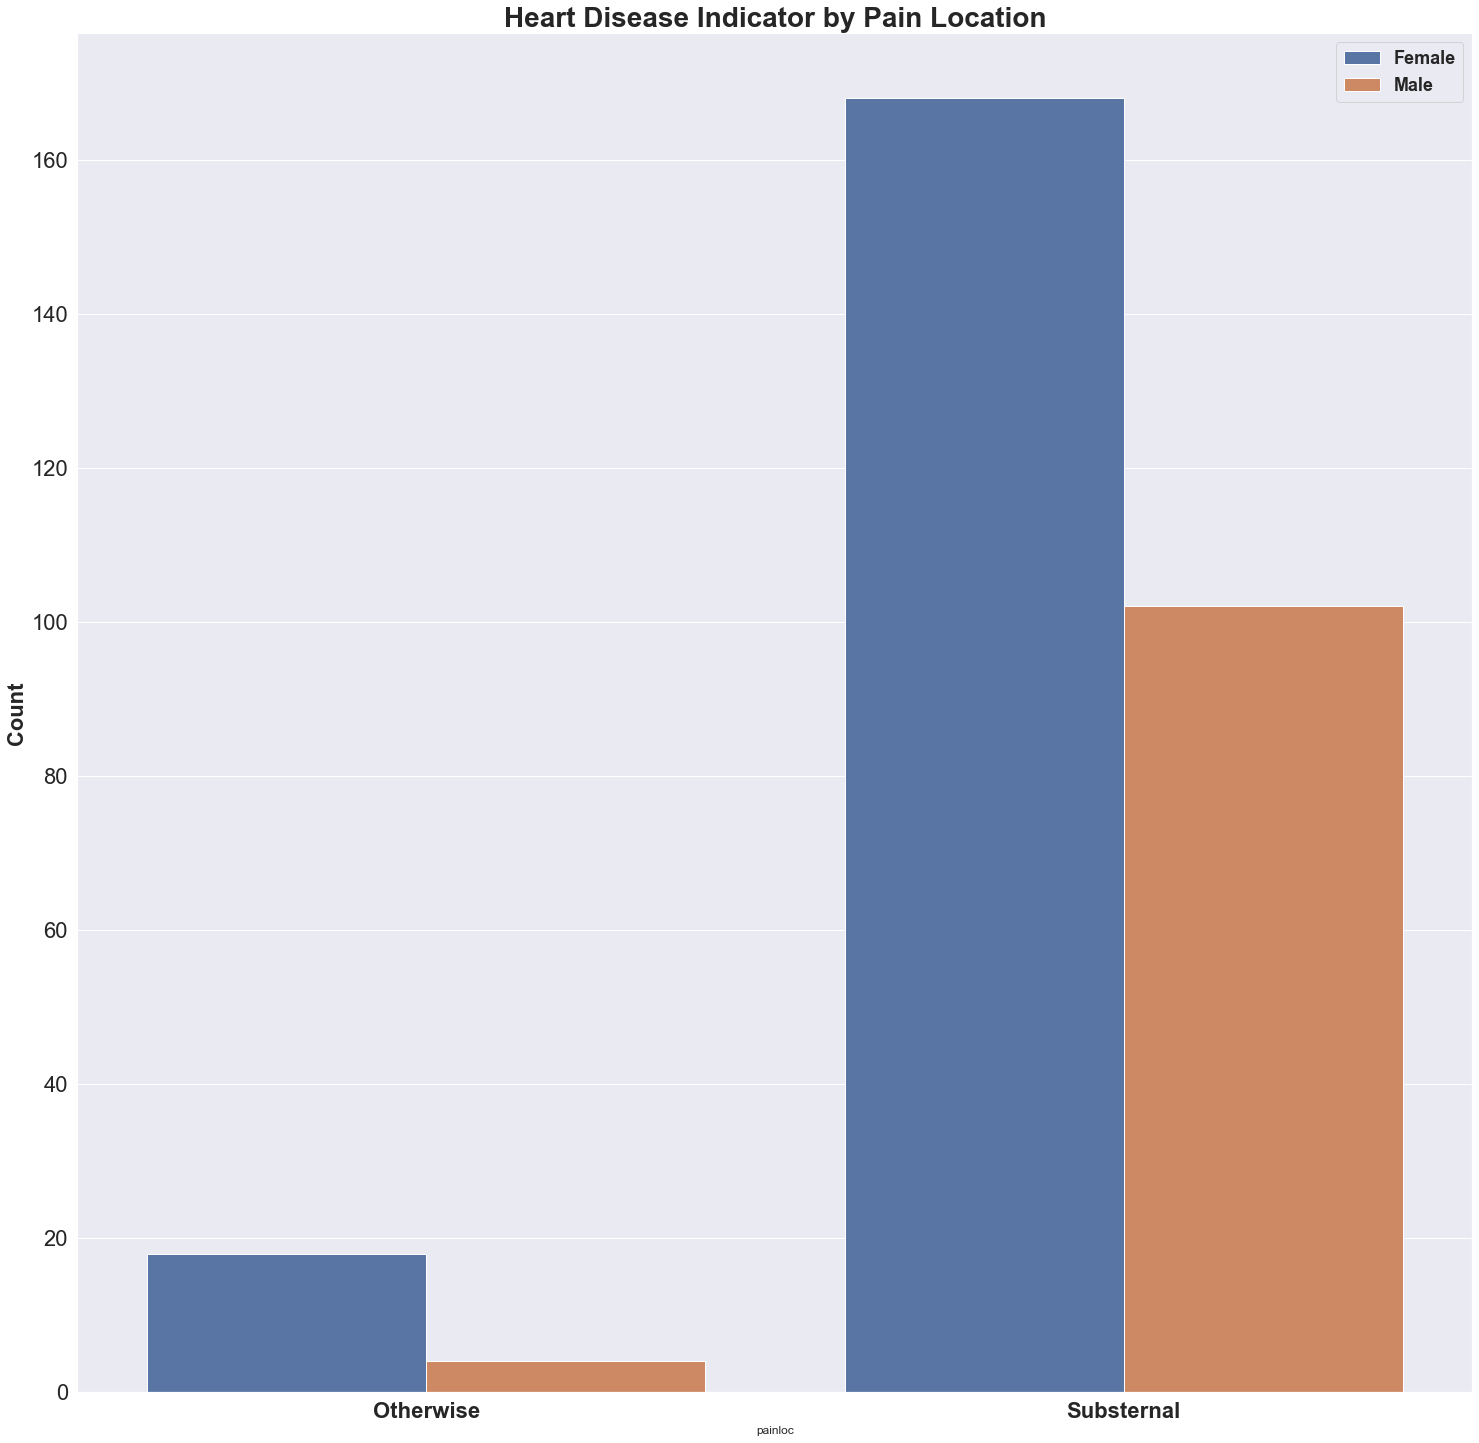

num        0    1
painloc          
0         18    4
1        168  102
The chi-square value for painloc and num is 2.5838848346862147, and the p-value is 0.1079564166907364, respectfully.
Fail to reject the null of no association between painloc and diagnosis of heart disease. The probability of a heart disease diagnosis is the same regardless of chest pain location.
               Estimate   SE   LCB    UCB  p-value
--------------------------------------------------
Odds ratio        2.732        0.900 8.299   0.076
Log odds ratio    1.005 0.567 -0.106 2.116   0.076
Risk ratio        1.315        1.058 1.635   0.014
Log risk ratio    0.274 0.111  0.056 0.492   0.014
--------------------------------------------------
The odds ratio is 2.732142857142857.


In [26]:
## Painloc
# Bar graph of painloc by num
plt.figure(figsize=figsize_dimensions)
painloc_dict = {0: "Otherwise", 1: "Substernal"}
ax = sns.countplot(x="painloc", hue="num", data=hungarian)
ax.set_title('Heart Disease Indicator by Pain Location', fontdict ={'fontweight': 'bold', 'fontsize': title_fontsize})
ax.set(xticklabels=painloc_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=font_size_label_size)
ax.yaxis.set_tick_params(labelsize=font_size_label_size)
ax.set_ylabel('Count', fontdict={'fontweight': 'bold', 'fontsize': font_size_label_size})
handles, legends = ax.get_legend_handles_labels()
plt.legend(handles,sex_dict.values(), loc='best', prop={'weight': 'bold', 'size': legend_size})
plt.show()

# Contingency table of painloc by num
contingency = pd.crosstab(index=hungarian.painloc, columns=hungarian.num)
print(contingency)
# Pearson chi-square test
chi, p, dof, expected = stats.chi2_contingency(contingency)
print(f"The chi-square value for {contingency.index.name} and {contingency.columns.name} is {chi}, and the p-value is"
      f" {p}, respectfully.")
if p <= strong_alpha_value:
    print(f"Reject the null hypothesis of no association between {contingency.index.name} and diagnosis of heart "
          f"disease and conclude there is an association between {contingency.index.name} and diagnosis of heart "
          f"disease. The probability of a heart disease diagnosis is not the same based on chest pain location.")
else:
    print(f"Fail to reject the null of no association between {contingency.index.name} and diagnosis of heart disease. "
          f"The probability of a heart disease diagnosis is the same regardless of chest pain location.")


# Compute odds ratio and risk ratio
table = sm.stats.Table2x2(contingency)
print(table.summary())
print(f"The odds ratio is {table.oddsratio}.")

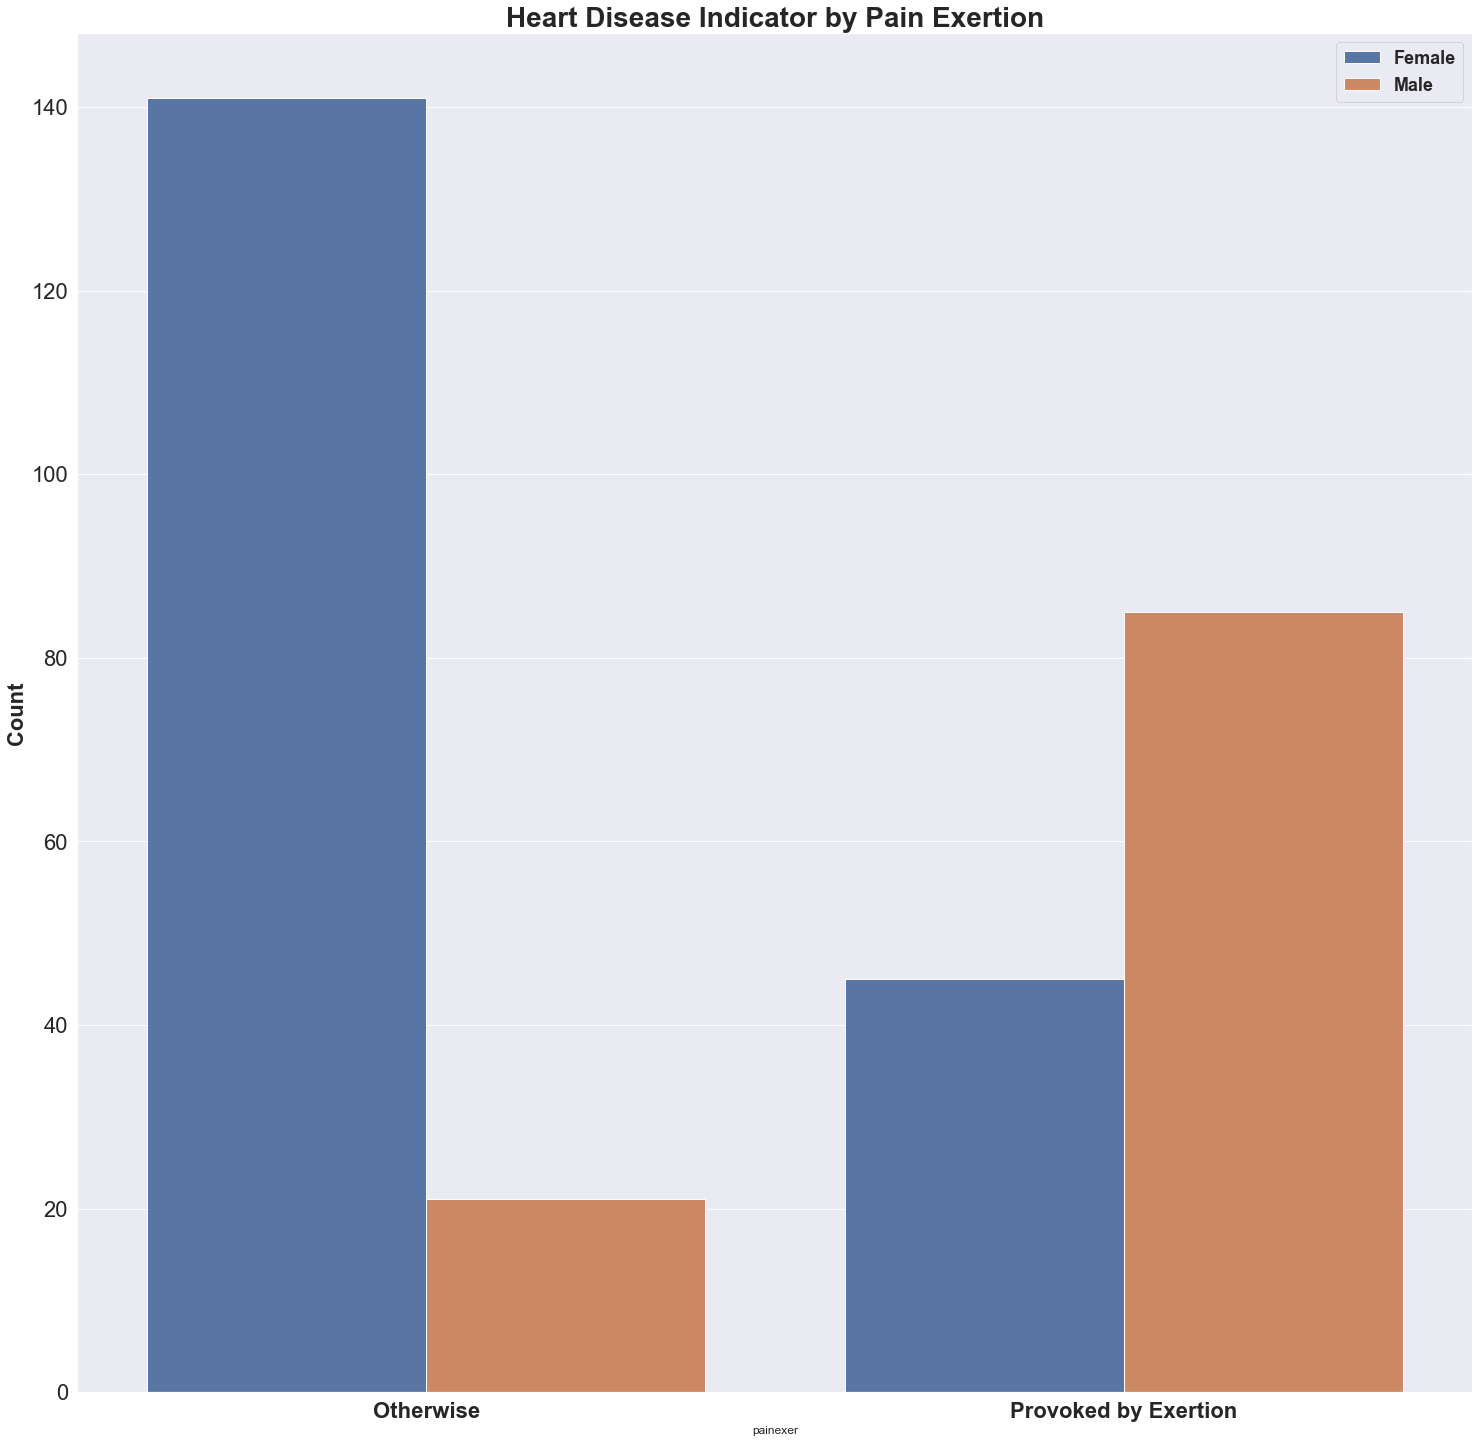

num         0   1
painexer         
0         141  21
1          45  85
The chi-square value for painexer and num is 83.46039138482502, and the p-value is 6.50054702954124e-20, respectfully. The expected values are
[[103.19178082  58.80821918]
 [ 82.80821918  47.19178082]].
Reject the null hypothesis of no association between painexer and diagnosis of heart disease and conclude there is an association between painexer and diagnosis of heart disease. The probability of a heart disease diagnosis is not the same based on how chest pain is provoked.
               Estimate   SE   LCB   UCB   p-value
--------------------------------------------------
Odds ratio       12.683       7.075 22.736   0.000
Log odds ratio    2.540 0.298 1.957  3.124   0.000
Risk ratio        2.514       1.971  3.208   0.000
Log risk ratio    0.922 0.124 0.678  1.166   0.000
--------------------------------------------------
The odds ratio is 12.682539682539682. This means patients with their chest pain provoked by

In [27]:
## Painexer
# Bar graph of painexer by num
plt.figure(figsize=figsize_dimensions)
painexer_dict = {0: "Otherwise", 1: "Provoked by Exertion"}
ax = sns.countplot(x="painexer", hue="num",
              data=hungarian)
ax.set_title('Heart Disease Indicator by Pain Exertion', fontdict ={'fontweight': 'bold', 'fontsize': title_fontsize})
ax.set(xticklabels=painexer_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=font_size_label_size)
ax.yaxis.set_tick_params(labelsize=font_size_label_size)
ax.set_ylabel('Count', fontdict={'fontweight': 'bold', 'fontsize': font_size_label_size})
handles, legends = ax.get_legend_handles_labels()
plt.legend(handles,sex_dict.values(), loc='best', prop={'weight': 'bold', 'size': legend_size})
plt.show()

# Contingency table of painexer by num
contingency = pd.crosstab(index=hungarian.painexer, columns=hungarian.num)
print(contingency)
# Pearson chi-square test
chi, p, dof, expected = stats.chi2_contingency(contingency)
print(f"The chi-square value for {contingency.index.name} and {contingency.columns.name} is {chi}, and the p-value is"
      f" {p}, respectfully. The expected values are\n{expected}.")
if p <= strong_alpha_value:
    print(f"Reject the null hypothesis of no association between {contingency.index.name} and diagnosis of heart "
          f"disease and conclude there is an association between {contingency.index.name} and diagnosis of heart "
          f"disease. The probability of a heart disease diagnosis is not the same based on how chest pain is provoked.")
else:
    print(f"Fail to reject the null of no association between {contingency.index.name} and diagnosis of heart disease. "
          f"The probability of a heart disease diagnosis is the same regardless of how chest pain is provoked.")

# Compute odds ratio and risk ratio
table = sm.stats.Table2x2(contingency)
print(table.summary())
print(f"The odds ratio is {table.oddsratio}. This means patients with their chest pain provoked by exertion are "
      f"{round(table.oddsratio,2)} times more likely to have a diagnosis of heart disease than those patients with "
      f"their chest pain provoked otherwise.")

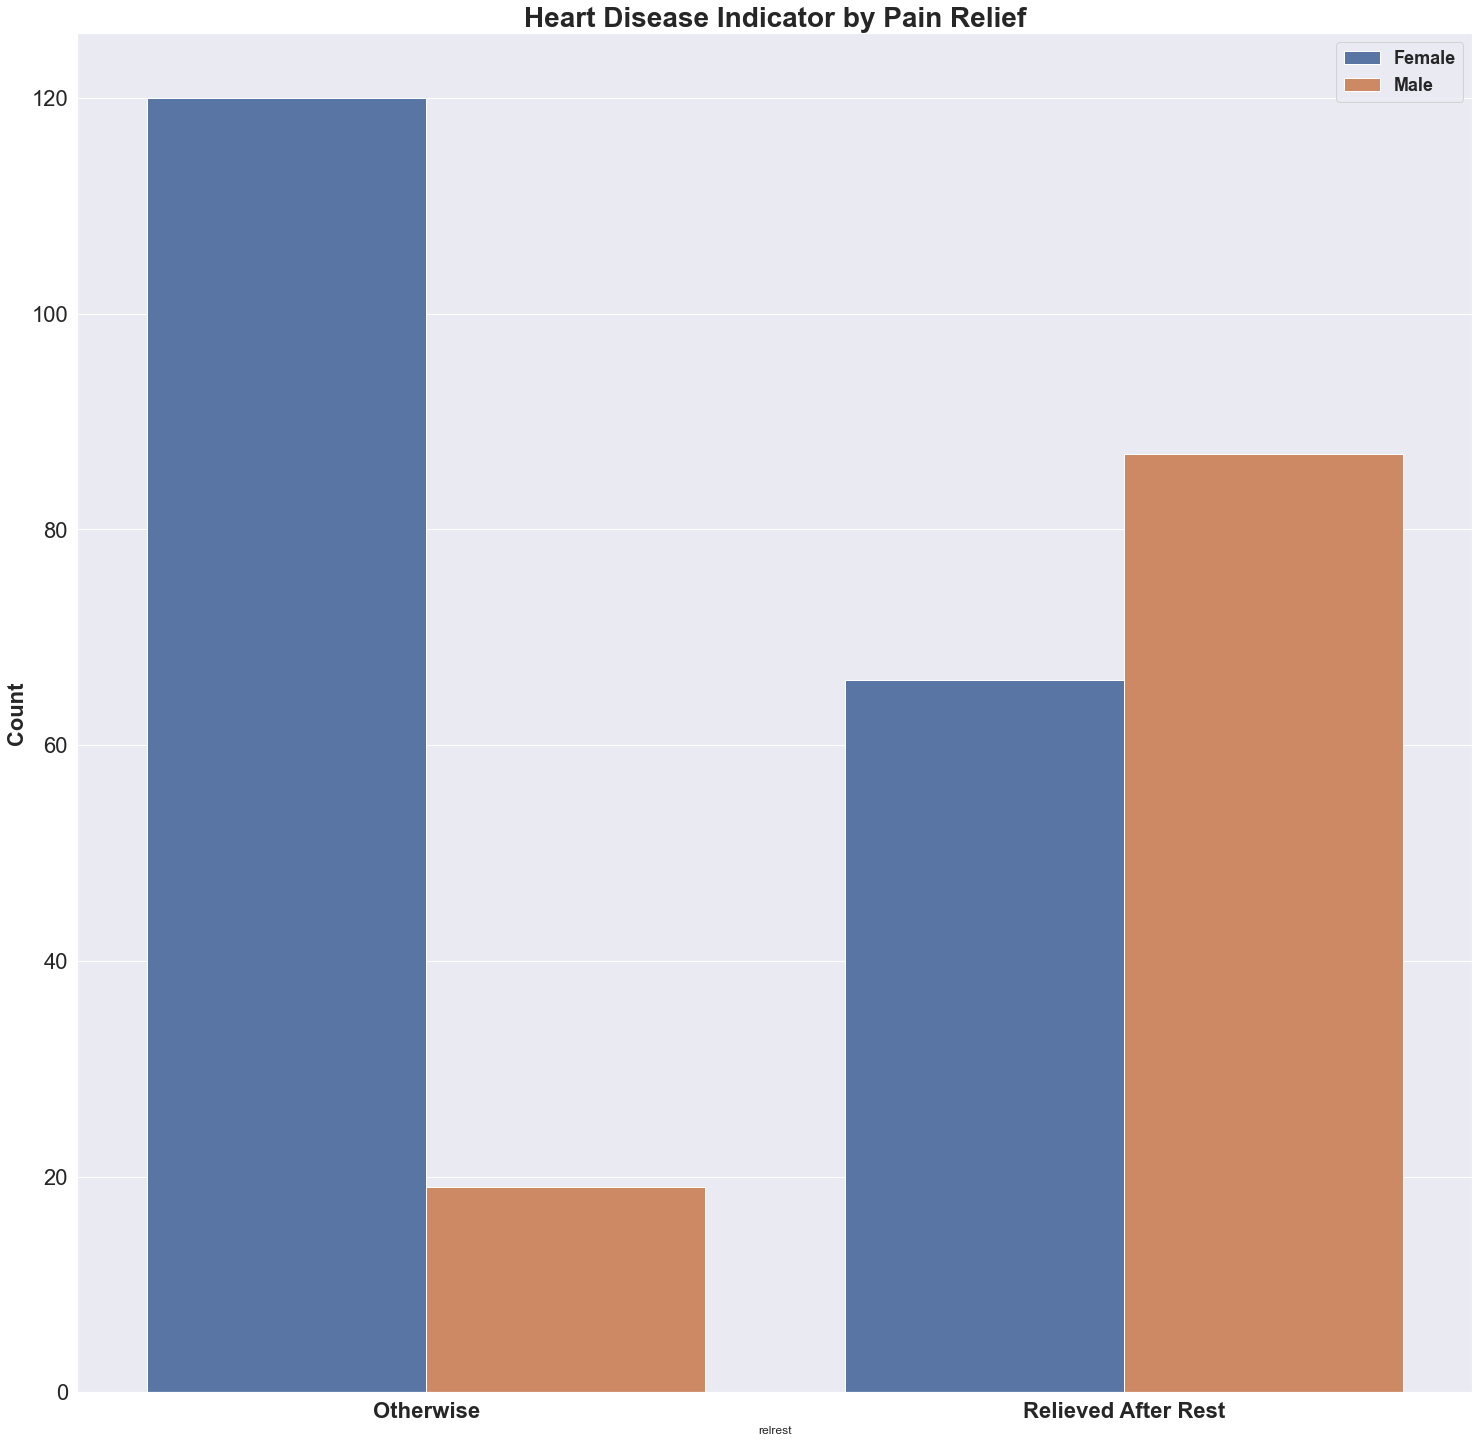

num        0   1
relrest         
0        120  19
1         66  87
The chi-square value for relrest and num is 56.91079754672746, and the p-value is 4.560350622794233e-14, respectfully. The expected values are
[[88.54109589 50.45890411]
 [97.45890411 55.54109589]].
Reject the null hypothesis of no association between relrest and diagnosis of heart disease and conclude there is an association between relrest and diagnosis of heart disease. The probability of a heart disease diagnosis is not the same for pain relieved after rest and otherwise.
               Estimate   SE   LCB   UCB   p-value
--------------------------------------------------
Odds ratio        8.325       4.661 14.871   0.000
Log odds ratio    2.119 0.296 1.539  2.699   0.000
Risk ratio        2.001       1.649  2.429   0.000
Log risk ratio    0.694 0.099 0.500  0.887   0.000
--------------------------------------------------
The odds ratio is 8.325358851674642. This means patients with their chest pain relieved after 

In [28]:
## Relrest
# Bar graph of relrest by num
plt.figure(figsize=figsize_dimensions)
relrest_dict = {0: "Otherwise", 1: "Relieved After Rest"}
ax = sns.countplot(x="relrest", hue="num", data=hungarian)
ax.set_title('Heart Disease Indicator by Pain Relief', fontdict ={'fontweight': 'bold', 'fontsize': title_fontsize})
ax.set(xticklabels=relrest_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=font_size_label_size)
ax.yaxis.set_tick_params(labelsize=font_size_label_size)
ax.set_ylabel('Count', fontdict={'fontweight': 'bold', 'fontsize': font_size_label_size})
handles, legends = ax.get_legend_handles_labels()
plt.legend(handles,sex_dict.values(), loc='best', prop={'weight': 'bold', 'size': legend_size})
plt.show()

# Contingency table of relrest by num
contingency = pd.crosstab(index=hungarian.relrest, columns=hungarian.num)
print(contingency)
# Pearson chi-square test
chi, p, dof, expected = stats.chi2_contingency(contingency)
print(f"The chi-square value for {contingency.index.name} and {contingency.columns.name} is {chi}, and the p-value is"
      f" {p}, respectfully. The expected values are\n{expected}.")
if p <= strong_alpha_value:
    print(f"Reject the null hypothesis of no association between {contingency.index.name} and diagnosis of heart "
          f"disease and conclude there is an association between {contingency.index.name} and diagnosis of heart "
          f"disease. The probability of a heart disease diagnosis is not the same for pain relieved after rest and "
          f"otherwise.")
else:
    print(f"Fail to reject the null of no association between {contingency.index.name} and diagnosis of heart disease. "
          f"The probability of a heart disease diagnosis is the same regardless of when the pain is relieved.")

# Compute odds ratio and risk ratio
table = sm.stats.Table2x2(contingency)
print(table.summary())
print(f"The odds ratio is {table.oddsratio}. This means patients with their chest pain relieved after rest are "
      f"{round(table.oddsratio,2)} times more likely to have a diagnosis of heart disease than those patients with "
      f"their chest pain relieved otherwise.")

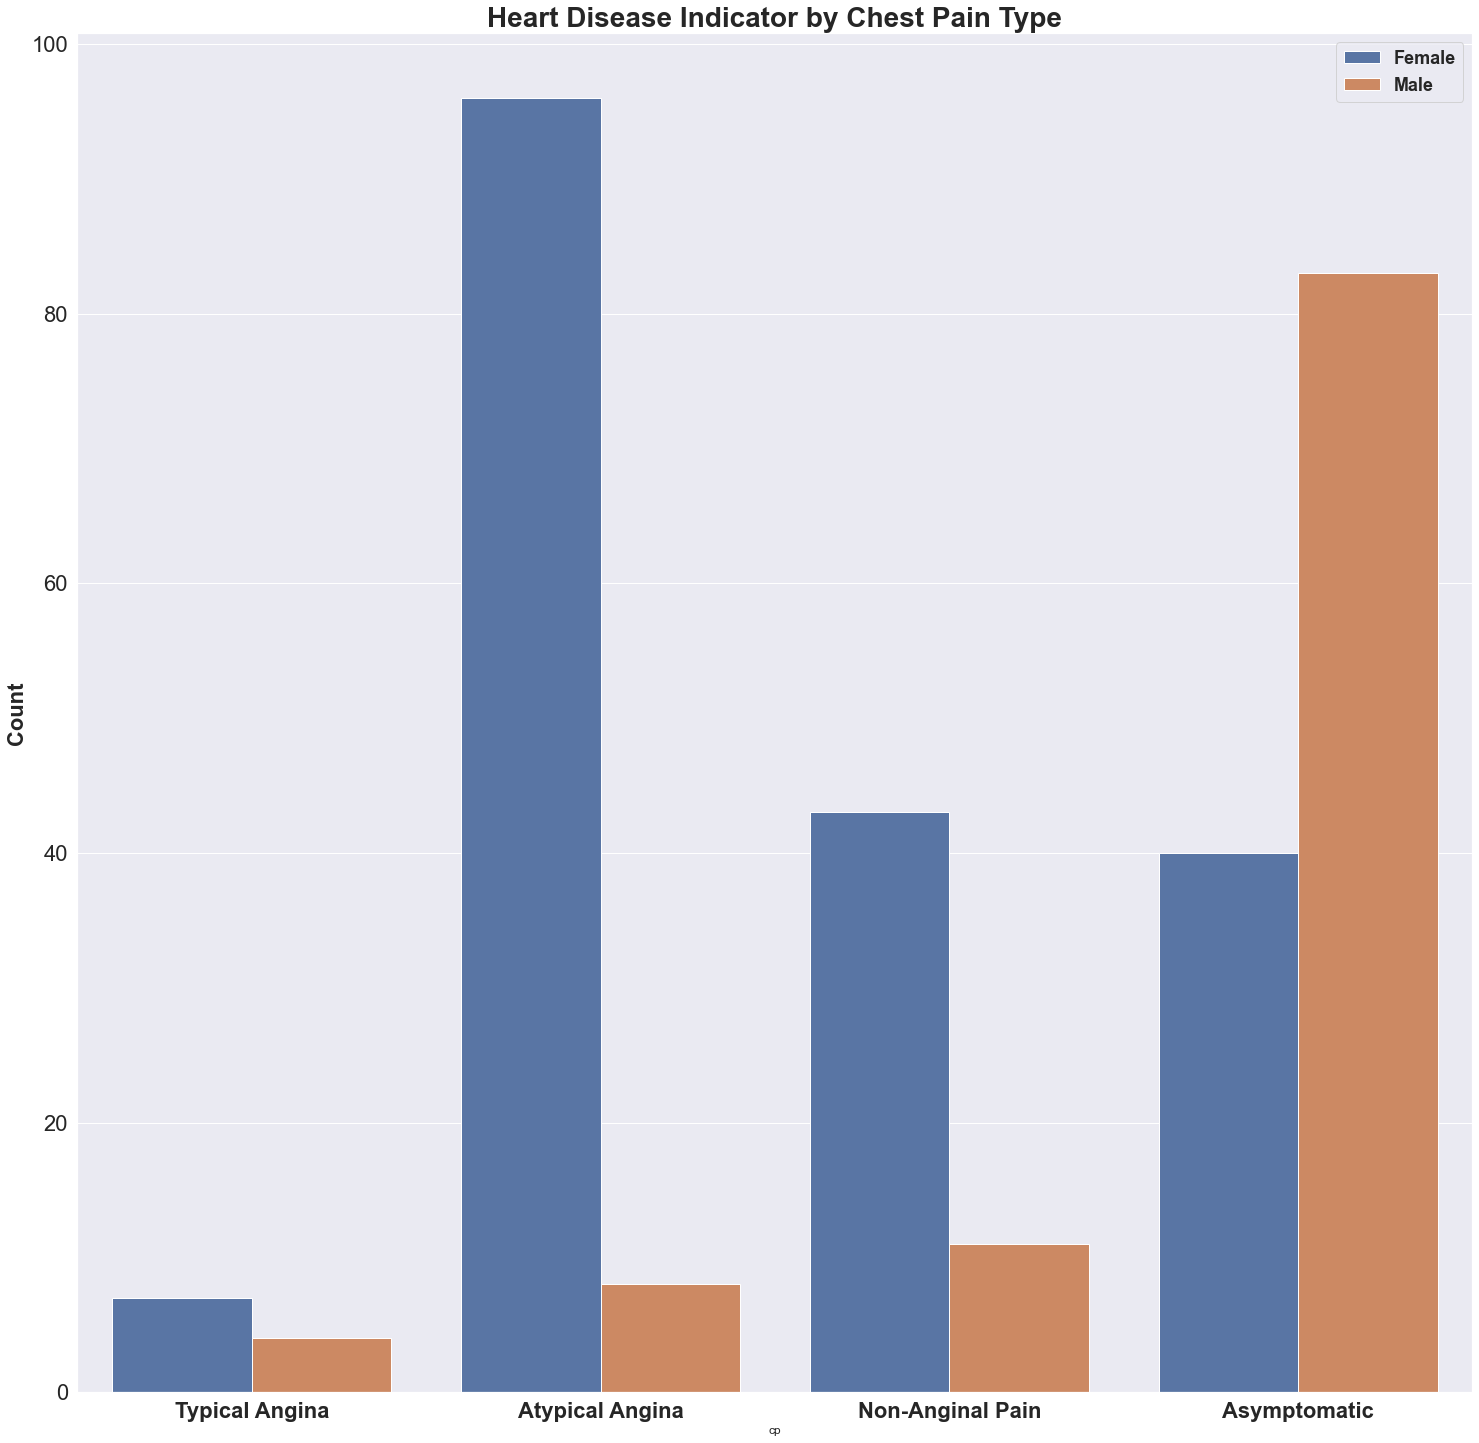

num   0   1
cp         
1     7   4
2    96   8
3    43  11
4    40  83
The chi-square value for cp and num is 94.44665445592759, and the p-value is 2.4278973764043244e-20, respectfully.
Reject the null hypothesis of no association between cp and diagnosis of heart disease and conclude there is an association between cp and diagnosis of heart disease. The probability of a heart disease diagnosis is not the same depending on chest pain type.


In [29]:
## Cp
# Bar graph of cp by num
plt.figure(figsize=figsize_dimensions)
cp_dict = {1: "Typical Angina", 2: "Atypical Angina", 3: "Non-Anginal Pain", 4: "Asymptomatic"}
ax = sns.countplot(x="cp", hue="num", data=hungarian)
ax.set_title('Heart Disease Indicator by Chest Pain Type', fontdict ={'fontweight': 'bold', 'fontsize': title_fontsize})
ax.set(xticklabels=cp_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=font_size_label_size)
ax.yaxis.set_tick_params(labelsize=font_size_label_size)
ax.set_ylabel('Count', fontdict={'fontweight': 'bold', 'fontsize': font_size_label_size})
handles, legends = ax.get_legend_handles_labels()
plt.legend(handles,sex_dict.values(), loc='best', prop={'weight': 'bold', 'size': legend_size})
plt.show()

# Contingency table of cp by cum
contingency = pd.crosstab(index=hungarian.cp, columns=hungarian.num)
print(contingency)
# Pearson chi-square test
chi, p, dof, expected = stats.chi2_contingency(contingency)
print(f"The chi-square value for {contingency.index.name} and {contingency.columns.name} is {chi}, and the p-value is"
      f" {p}, respectfully.")
if p <= strong_alpha_value:
    print(f"Reject the null hypothesis of no association between {contingency.index.name} and diagnosis of heart "
          f"disease and conclude there is an association between {contingency.index.name} and diagnosis of heart "
          f"disease. The probability of a heart disease diagnosis is not the same depending on chest pain type.")
else:
    print(
        f"Fail to reject the null of no association between {contingency.index.name} and diagnosis of heart disease. "
        f"The probability of a heart disease diagnosis is the same regardless of chest pain type.")

In [30]:
# Feature engineering
hungarian["thalach_div_by_thalrest"] = hungarian["thalach"]/hungarian["thalrest"]
hungarian["tpeakbps_div_by_tpeakbpd"] = hungarian["tpeakbps"]/hungarian["tpeakbpd"]
hungarian["thaldur_div_by_met"] = hungarian["thaldur"]/hungarian["met"]
hungarian["chol_div_by_age"] = hungarian["chol"]/hungarian["age"]
hungarian["chol_div_by_met"] = hungarian["chol"]/hungarian["met"]
hungarian["chol_div_by_thalach"] = hungarian["chol"]/hungarian["thalach"]
hungarian["chol_div_by_thalrest"] = hungarian["chol"]/hungarian["thalrest"]
hungarian["thalrest_div_by_rldv5"] = hungarian["thalrest"]/hungarian["rldv5"]
hungarian["thalach_div_by_rldv5e"] = hungarian["thalrest"]/hungarian["rldv5e"]

hungarian["trestbps_boxcox_div_by_tpeakbpd"] = hungarian["trestbps_boxcox"]/hungarian["tpeakbpd"]

hungarian["chol_boxcox_div_by_age"] = hungarian["chol_boxcox"]/hungarian["age"]
hungarian["chol_boxcox_div_by_met"] = hungarian["chol_boxcox"]/hungarian["met"]
hungarian["chol_boxcox_div_by_thalach"] = hungarian["chol_boxcox"]/hungarian["thalach"]
hungarian["chol_boxcox_div_by_thalrest"] = hungarian["chol_boxcox"]/hungarian["thalrest"]

hungarian["thalach_div_by_thalrest_boxcox"] = hungarian["thalach"]/hungarian["thalrest_boxcox"]
hungarian["chol_div_by_thalrest_boxcox"] = hungarian["chol"]/hungarian["thalrest_boxcox"]
hungarian["thalrest_boxcox_div_by_rldv5"] = hungarian["thalrest_boxcox"]/hungarian["rldv5"]

# Bin age
hungarian['agebinned'] = pd.cut(x=hungarian.age, bins=5, labels = ['0', '1', '2', '3', '4'])

# Add boxcox'd variables to continuous_variables list
continuous_variables.extend([x for x in list(hungarian) if 'boxcox' in x])
# Add interaction variables to continuous_variables list
continuous_variables.extend([x for x in list(hungarian) if 'div_by' in x])

In [31]:
# Correlations > 0.6 and < 1.0 and <-0.6 and >-1.0, drop all null columns
hungarian[continuous_variables].corr()[((hungarian[continuous_variables].corr() > 0.6) &
                                              (hungarian[continuous_variables].corr() < 1.0)) |
                                             ((hungarian[continuous_variables].corr()<-0.6) &
                                              (hungarian[continuous_variables].corr()>-1.0))].dropna(axis=1, how='all')

,age,trestbps,chol,thaldur,met,thalach,thalrest,tpeakbpd,trestbpd,rldv5,rldv5e,rldv5_rldv5e_pca,trestbps_boxcox,chol_boxcox,thalrest_boxcox,trestbps_boxcox_div_by_tpeakbpd,chol_boxcox_div_by_age,chol_boxcox_div_by_met,chol_boxcox_div_by_thalach,chol_boxcox_div_by_thalrest,thalach_div_by_thalrest_boxcox,chol_div_by_thalrest_boxcox,thalrest_boxcox_div_by_rldv5,thalach_div_by_thalrest,thaldur_div_by_met,chol_div_by_age,chol_div_by_met,chol_div_by_thalach,chol_div_by_thalrest,thalrest_div_by_rldv5,thalach_div_by_rldv5e,trestbps_boxcox_div_by_tpeakbpd,chol_boxcox_div_by_age,chol_boxcox_div_by_met,chol_boxcox_div_by_thalach,chol_boxcox_div_by_thalrest,thalach_div_by_thalrest_boxcox,chol_div_by_thalrest_boxcox,thalrest_boxcox_div_by_rldv5
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.947679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.947679,NaN,NaN,NaN,NaN,NaN,NaN
trestbps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.644058,NaN,NaN,NaN,0.985489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.970146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.989822,NaN,NaN,NaN,0.799275,NaN,0.833354,0.795216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.989822,NaN
thaldur,NaN,NaN,NaN,NaN,0.780905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.718348,NaN,NaN,NaN,NaN,NaN,NaN,0.679641,NaN,-0.629189,NaN,NaN,NaN,NaN,NaN,NaN,-0.718348,NaN,NaN,NaN,NaN,NaN
met,NaN,NaN,NaN,0.780905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.879142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.777640,NaN,NaN,NaN,NaN,NaN,NaN,-0.879142,NaN,NaN,NaN,NaN,NaN
thalach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.954071,NaN,0.976764,NaN,NaN,NaN,NaN,NaN,NaN,-0.624562,NaN,NaN,NaN,NaN,NaN,NaN,-0.954071,NaN,0.976764,NaN,NaN
thalrest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990762,NaN,NaN,NaN,NaN,-0.943783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.943783,NaN,NaN,NaN
tpeakbps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tpeakbpd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.983585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.983585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trestbpd,NaN,0.644058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
